## AJ Data Pre-Processing

In [3]:
import os
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import re
import csv
import json
import numpy as np
import tcxparser
import glob
import time
import statistics
import numpy
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import pandas as pd
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
import seaborn as sns
from pmdarima.arima import auto_arima
from pandas.plotting import autocorrelation_plot
from sklearn.metrics import r2_score
from statsmodels.tsa.arima_model import ARIMA
import sklearn.metrics
import math
import warnings

#### Relevant Parameters of interest (user specific)

In [ ]:
paths_to_data = {'fit':'../Data/Juan/Run/Fit', 'arduino':'../Data/Juan/Run'}
data_dir = '../Data/Juan/Run/'

path_to_tcx = 'Actividades/*_Correr.tcx'

file_names = sorted(glob.iglob(os.path.join(paths_to_data['fit'], path_to_tcx)))

distance_vec = [40]*30

In [ ]:
def missing_data_treatment(data, method='interpolation'):
    """
    We see that the arduino app generates a lot of missing data points. We will implement a few different approaches to 
    deal with this missing data:
    :param method: (str) The methods we will implement are:
        - 'constant': Will adopt the value of the previous observation
        - 'interpolation': Interpolate the data since we are in a continuous domain
        - 'nearest': Adopts the value of the nearest value
    """
    df = data.copy()
    if method == 'interpolation':
        df.interpolate(method='linear', inplace=True)
    elif method == 'constant':
        df.interpolate(method='zero', inplace=True)
    elif method == 'nearest':
        df.interpolate(method='nearest', inplace=True)
    else:
        raise ValueError('The method specified is not defined. Please review function missing_data_treeatment')
    return df

In [ ]:
def session_start(data, method='inference', value=None):
    """
    Sessions don't start in the moment in which Arduino starts recording data. There are a few residual seconds before
    we actually start running (e.g. setting up device). 
    We will implement 3 different methods:
    :param method: (str) 
        - 'inference': Look at the data and try to guess when we are actually starting to run. The idea until now is:
                - Look at the X, Y and Z axis for each user and see the most regular one (depends on how the device is placed).
                - Based on the best feature, estimate the average amplitude of a step (Avarage amplitude is calculated for each interval of n measurements)
                - Start is defined as the starting point of the first interval wich passes the avg threshold.
                - End is defined as the starting point of the first interval (from the end of the time series) wich passes the avg threshold.
                - Set the timer at the stage in which the amplitude is below a certain threshold
        - 'percentage': Remove the initial 2% of the observations (try to be conservative, better to remove part of the session
                        than keep irrelevant data)
        - 'fixed': Set a fixed starting point (not recommended but  can be usefull for testing purposes)
    :param value: (depends) If the method is  inference leave the default value, if the method is percentage provide float 
                  between 0 and 1 (e.g. 0.02 to remove  2% of the initial data set), if the method is fixed provide a string 
                  with date format (e.g. '2021-05-02 18:01:00')
    """
    
    df = data.copy().dropna()
    if method == 'inference':
        
        n = 100 # n=100 seemed like a good compromise to me in order to avoid detecting local changes.
        Y = [abs(x) for x in df.AccY.tolist()]
        ampl = [statistics.mean(Y[x:x+n]) for x in range(1,(len(Y)//n)*n,n)]
        start = np.where(np.array(ampl) > statistics.mean(ampl))[0][0]*n
        end = np.where(np.array(ampl[::-1]) > statistics.mean(ampl))[0][0]*n
        start_timestamp = df.iloc[[start]].index[0]
        end_timestamp = df.iloc[[len(Y)-end-1]].index[0]
        print('Number of observations excluded with inference method:', start+end)
        
        ########################## to be deleted, just for check
        plt.figure(figsize=(20,8))
        plt.plot(df.AccY.tolist(),color='#F7EBE8')
        plt.axvline(x=start, color='g', linestyle='--')
        plt.axvline(x=len(Y)-end, color='r', linestyle='--')
        plt.show()
        #######################################################
        
        df = df[df.index > start_timestamp]
        df = df[df.index < end_timestamp]
        
    elif method == 'percentage':
        length = len(data)*value
        df = df[int(length):]
    elif method == 'fixed':
        df = df[df > value]
    else:
        raise ValueError('The method specified is not defined. Please review function session_start')
    
    return df

In [ ]:
def generate_full_time_series_AJ(path, file_identifier='Run_', plot=None, google_files=file_names, period=1,
                                 independence_df=False, distance=distance_vec, feature='AccY', plot_check=[1000,1500],
                                 step_per_peak=1, history=2, time_interval='5S'):
    
    """
    We have decided to generate a full time series as dataset (i.e. put all the sessions together, making several 
    time series into a single one). For this purpose we will simply do individual pre-processing steps on each 
    of the csv files and then merge everything together
    :param path: (str) Folder in which csv files can be found
    :param file_identifier: (str) Identifier of each csv file
    :param period: Number of periods between pace run
    :param independence_df: If true we will generate dataframes assuming independence
    :param distance: Used only for the step function detector
    :param feature: Used only for the step function detector
    :param plot_check: Used only for the step function detector
    :param history: How much back do we want to go to remove independence?
    :param time_interval: Aggregation time interval
    """
    session_files =  [i for i in os.listdir(path) if re.search(file_identifier, i)] 
    full_df = pd.DataFrame()
    
    google_df = load_tcx(google_files)
    j=0
    for session in session_files:
        print('Session Identifier: ', re.findall('\d+', session)[0])
        df = pd.read_csv(path + session)
        df['timestamp'] = df.apply(lambda x: datetime.fromtimestamp(x['timestamp'] / 1000).strftime('%Y-%m-%d %H:%M:%S.%f')[:-3] ,axis=1)
        df['timestamp'] = pd.to_datetime(df['timestamp'])
        df = df.set_index('timestamp')
        df_missing = missing_data_treatment(df, method='interpolation')
        df_start = session_start(df_missing, method='inference',value=None)
        #print('Session Start: ' + str(min(df_start.index)))
        #print('Session End: ' + str(max(df_start.index)))
        reduce_tcx_df = google_df[(google_df.timestamp > str(min(df_start.index))) & 
                                  (google_df.timestamp < str(max(df_start.index)))].set_index('timestamp')
        
        
        #return reduce_tcx_df, df_start
        # Intermediate step to remove google data duplicates for distance and altitude seperately
        reduce_tcx_df.reset_index(level=0, inplace=True)
        dist_df = reduce_tcx_df.groupby('distance').last().reset_index(level=0).set_index('timestamp')
        alt_df = reduce_tcx_df.groupby('altitude').last().reset_index(level=0).set_index('timestamp')
        
        merged = df_start.merge(dist_df[['distance', 'google_fit']], how='outer', sort=True, on='timestamp')
        merged['distance'] = merged['distance'].interpolate(method='index')
        
        merged = merged.merge(alt_df[['altitude', 'google_fit']], how='outer', sort=True, on='timestamp')
        merged['altitude'] = merged['altitude'].interpolate(method='index')
        
        
        df_final = merged[~(merged.google_fit_x == True) | ~(merged.google_fit_y == True)]
        #df_final.dropna(subset=['altitude', 'distance'], inplace=True)
        df_final.drop(columns=['google_fit_x', 'google_fit_y'], inplace=True)
        df_final = df_final[(df_final.index > str(min(df_start.index))) & 
                             (df_final.index < str(max(df_start.index)))]
        
        # Add pace to as feature
        df_final['delta_distance']= df_final.distance.diff(periods=period)
        df_final['delta_altitude']= df_final.distance.diff(periods=period)
        df_final['delta_time'] = [0]*period+[(df_final.index[i]-df_final.index[i-period]).total_seconds() 
                                                for i in range(period,df_final.shape[0])]
        df_final = df_final[period:]
        df_final['pace']=(df_final.delta_distance/1000)/(df_final.delta_time/3600)
        
        if independence_df:
            df_peaks = identify_peaks(df_final, feature=feature, plot_check=plot_check, distance=distance_vec[j],
                                      step_per_peak=step_per_peak)
            df_agg = df_aggregation(df_peaks, time_interval=time_interval, history=history)
            df_agg.dropna(inplace=True)
            full_df = pd.concat([full_df, df_agg])
        else:
            full_df = pd.concat([full_df, df_final])        
        print('+++++++++++++++')
        j+=1
        
    print('Finished pre-processing individual time series')
    full_df.sort_values(by='timestamp', inplace=True)
    
    if plot:
        plt.figure(figsize=(20, 12))
        plt.plot(full_df[plot])
        plt.show()
     
    
    return full_df
    

In [ ]:
def load_tcx(file_list):
   
    """
    Load tcx files into pandas DataFrame
    
    Known issue: 
    the lists altitude, timestamp and distance have not the same length;
    we don't know the position of the missing data (potential values' shift);
    """
    df = pd.DataFrame(columns=['timestamp','altitude',
                               'distance', 
                               'google_fit'])
    
    for file in file_list:
        tcx_obj = tcxparser.TCXParser(file)
        default_len = min([len(tcx_obj.time_values())],
                          [len(tcx_obj.altitude_points())],
                          [len(tcx_obj.distance_values())])[0]
        data_dict = {'timestamp':tcx_obj.time_values()[-default_len:], 
                     'altitude':tcx_obj.altitude_points()[-default_len:], 
                     'distance':tcx_obj.distance_values()[-default_len:],
                     'google_fit': [True] * default_len}
        tmp_df = pd.DataFrame.from_dict(data_dict)
        df = pd.concat([df, tmp_df], ignore_index=True)
        print('======================')
        
    df["timestamp"] = pd.to_datetime(df["timestamp"], format="%Y-%m-%dT%H:%M:%S.%fZ")
    hours_added = timedelta(hours = 2)
    df['timestamp'] = df['timestamp'] + hours_added
    df['distance'] = pd.to_numeric(df.distance.astype(str))
        
    return df.sort_values(by='timestamp')

In [ ]:
def identify_peaks(data, feature='AccY', height=0, distance=20, plot_check=[10000, 15000], step_per_peak=1):
    """
    For this function we provide a dataset and we return the same dataset with two additional features:
     - step: Indicator of when a set has been made. Since this estimation is based on the Acc it will in reality be 2 steps
     - peak_height: Moment in which the peak was identified, what was the height of the peak
    :param data: Dataframe where we will include the features
    :param feature: What is the feature variable over which this estimation will be done (this will depend on the run session)
    :param height: Reference value for peak_height
    :param distance: Minimum distance in index terms between two peaks. This is a tunning parameter which depends on the 
        session
    :param step_per_peak: How many steps for each peak detected
    :param plot_check: If provided, as output we will also get a plot to see whether the step checker has worked properly
    **Disclaimer: This is not an exact appproach, rather an approximation. Therefore this should be done ideally for each
        individual session independently
    """
    
    df = data.copy()
    x = np.array(df[feature])
    peaks, properties = find_peaks(x, height=height, distance=distance)
    if plot_check:
        plt.figure(figsize=(15, 8))
        plt.plot(x)
        plt.plot(peaks, x[peaks], "x")
        plt.plot(np.zeros_like(x), "--", color="gray")
        plt.xlim(plot_check[0], plot_check[1])
        plt.show()
    
    step = [0]*len(df)
    peak_height = [0]*len(df)
    j = 0
    for i in peaks:
        step[i] = step_per_peak
        peak_height[i] = properties['peak_heights'][j]
        j+=1

    df['step'] = step
    df['peak_height'] = peak_height
    
    return df

In [ ]:
def df_aggregation(df, time_interval='5S', history=2):
    
    features = [i for i in df.columns.to_list() if (i[0] != 'C') & (i[0] != 'M') & (i[0] != 'P')]
    df = df[features]
    
    # Perform aggregation
    ind_df = df.groupby(pd.Grouper(freq=time_interval)).agg({'AccX':['min', 'max', 'mean', 'median', 'std'], 
                                                        'AccY':['min', 'max', 'mean', 'median', 'std'],
                                                        'AccZ':['min', 'max', 'mean', 'median', 'std'],
                                                        'DecibelSource':['min', 'max', 'mean', 'median', 'std'],
                                                        #'PitchSensor':['min', 'max', 'mean', 'median', 'std'],
                                                        'LinearAccelerometerSensor':['min', 'max', 'mean', 'median', 'std'],
                                                        #'MagneticRotationSensor':['min', 'max', 'mean', 'median', 'std'],
                                                        #'CompassSensor':['min', 'max', 'mean', 'median', 'std'],
                                                        'step':['sum'],
                                                        'peak_height':['max'],
                                                        'pace':['min', 'max', 'mean', 'median', 'std'],
                                                        'delta_altitude':['min', 'max', 'mean', 'median', 'std']})
    ind_df.columns = ['_'.join(col).strip() for col in ind_df.columns.values]
    
    step_per_min = ind_df.rolling('1min').agg({"step_sum": "sum"})
    
    ind_df = ind_df.drop('step_sum', axis=1).merge(step_per_min, left_index=True, right_index=True)
    ind_df = ind_df[60:]
    
    # Now that aggregation is done we can get history variables which might be useful for prediction
    colnames = ind_df.columns.to_list()
    colnames.remove('step_sum')
    for feature in colnames:
        for i in range(history):
            ind_df[feature+'_previous_' + str(i+1)] = np.roll(ind_df[feature], i+1)
    
    ind_df = ind_df[history:]
    
    return ind_df

In [ ]:
pd.set_option('mode.chained_assignment', None)

full = generate_full_time_series_AJ('../Data/Juan/Run/', #file_identifier='Run_2404',
                                    plot=False, google_files=file_names, period=1,
                                    independence_df=True, distance=distance_vec, feature='AccY', 
                                    plot_check=[10000,12000], history=3, step_per_peak=1, time_interval='1S')

Text(0.5, 1.0, 'Steps per Minute Distribution Runner 2')

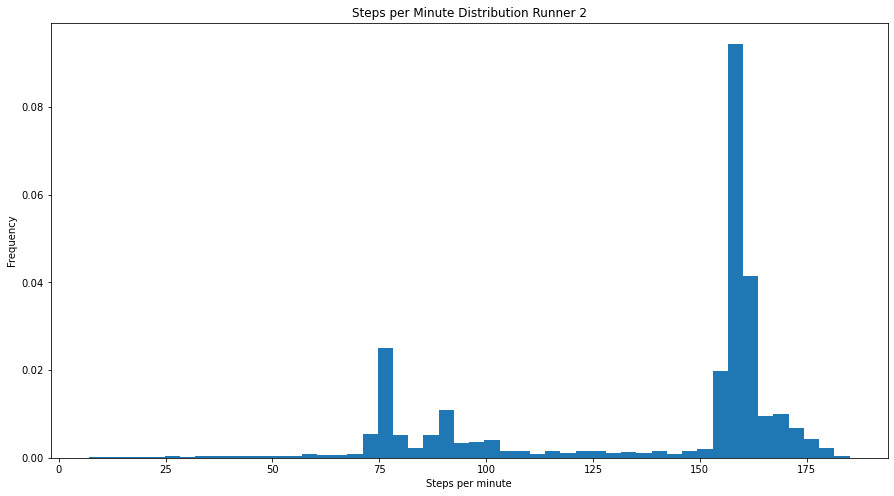

In [14]:
plt.figure(figsize=(15, 8))
plt.hist(full_juan['step_sum'], bins=50, density=True)
plt.xlabel('Steps per minute')
plt.ylabel('Frequency')
plt.title('Steps per Minute Distribution Runner 2')

Text(0.5, 1.0, 'Steps per Minute Distribution Runner 1')

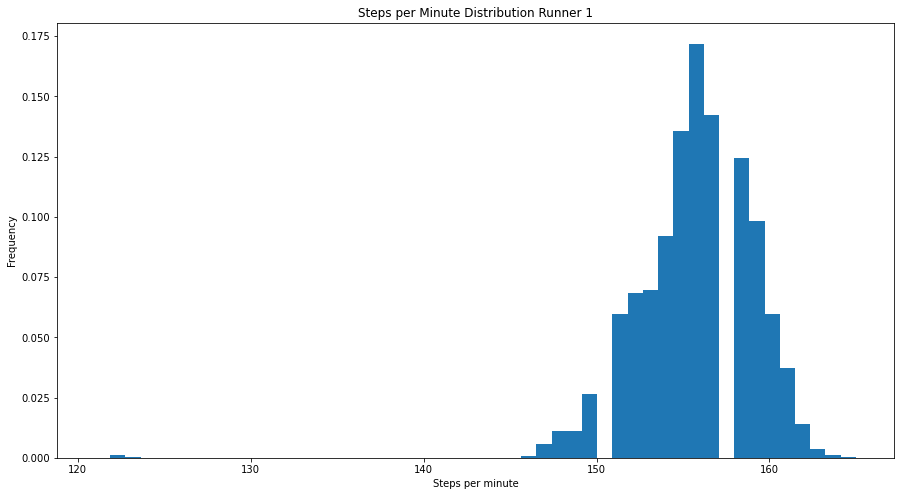

In [15]:
plt.figure(figsize=(15, 8))
plt.hist(full_stefano['step_sum'], bins=50, density=True)
plt.xlabel('Steps per minute')
plt.ylabel('Frequency')
plt.title('Steps per Minute Distribution Runner 1')

Text(0.5, 1.0, 'Steps per Minute Distribution Runner 3')

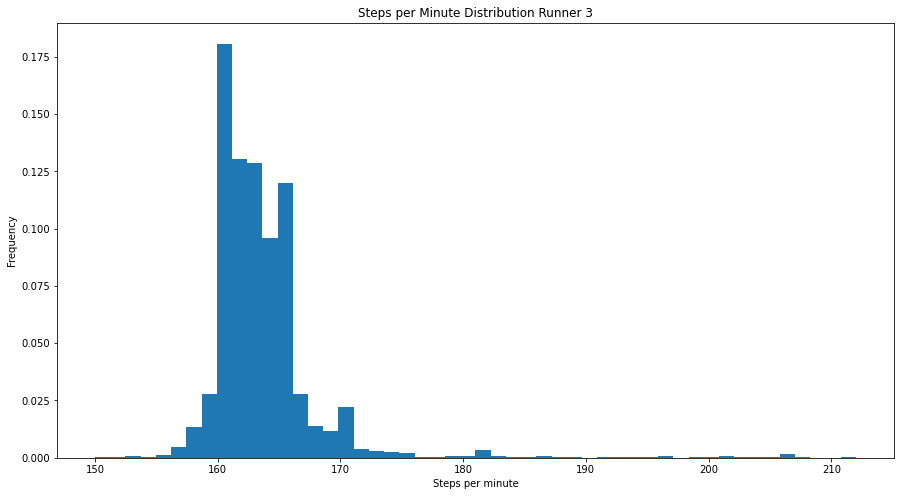

In [245]:
plt.figure(figsize=(15, 8))
plt.hist(full_leo['step_sum'], bins=50, density=True)
plt.xlabel('Steps per minute')
plt.ylabel('Frequency')
plt.title('Steps per Minute Distribution Runner 3')

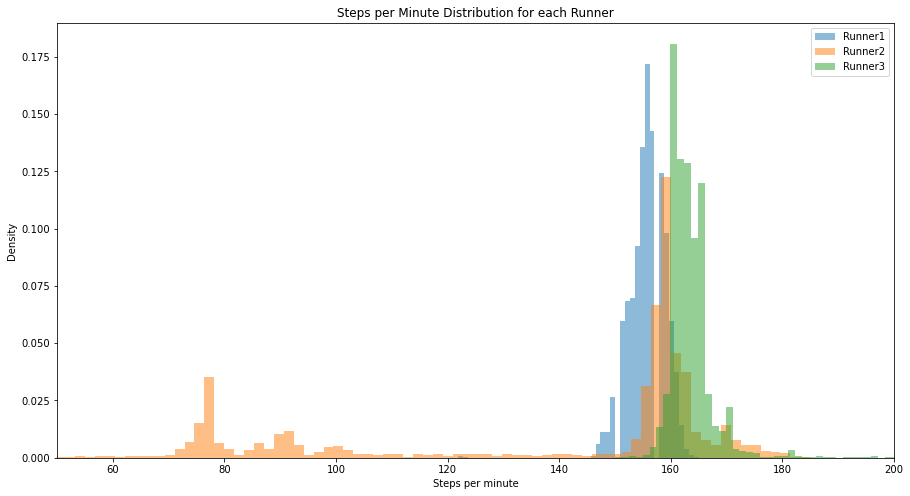

In [261]:
plt.figure(figsize=(15,8))
plt.hist(full_stefano['step_sum'], bins=50, density=True, alpha=0.5, label="Runner1")
plt.hist(full_juan['step_sum'], bins=100, density=True, alpha=0.5, label="Runner2")
plt.hist(full_leo['step_sum'], bins=50, density=True, alpha=0.5, label="Runner3")
plt.xlabel('Steps per minute')
plt.ylabel('Density')
plt.title('Steps per Minute Distribution for each Runner')
plt.legend(loc='upper right')
plt.xlim([50, 200])
plt.savefig("histograms.png")

Text(0.5, 1.0, 'Steps per Minute Boxplot Runner 1')

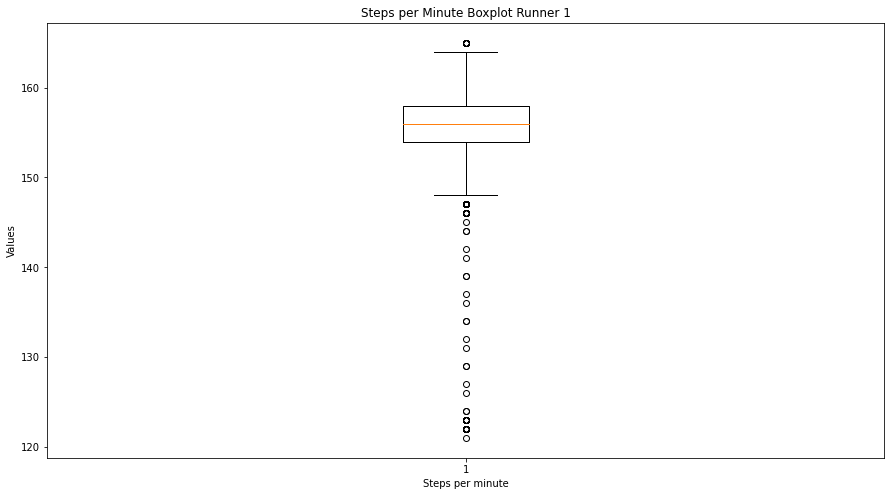

In [21]:
plt.figure(figsize=(15, 8))
plt.boxplot(full_stefano['step_sum'])
plt.xlabel('Steps per minute')
plt.ylabel('Values')
plt.title('Steps per Minute Boxplot Runner 1')

Text(0.5, 1.0, 'Steps per Minute Boxplot Runner 2')

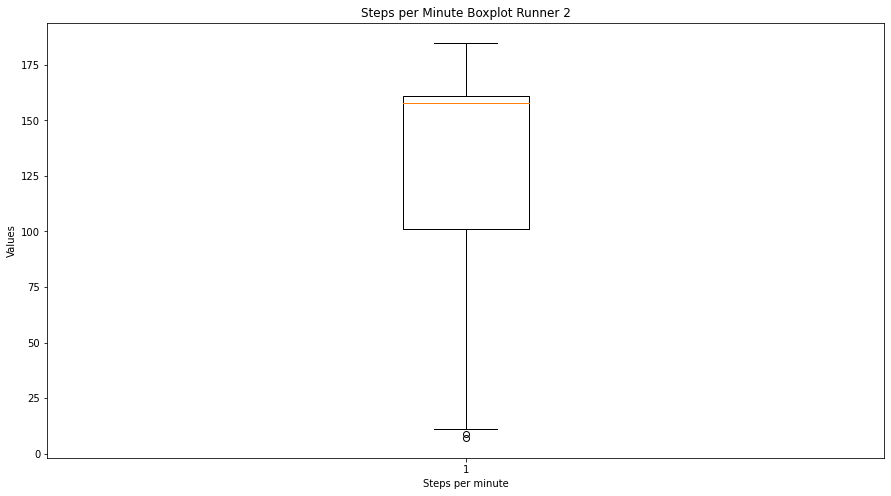

In [24]:
plt.figure(figsize=(15, 8))
plt.boxplot(full_juan['step_sum'])
plt.xlabel('Steps per minute')
plt.ylabel('Values')
plt.title('Steps per Minute Boxplot Runner 2')

Text(0.5, 1.0, 'Steps per Minute Boxplot Runner 3')

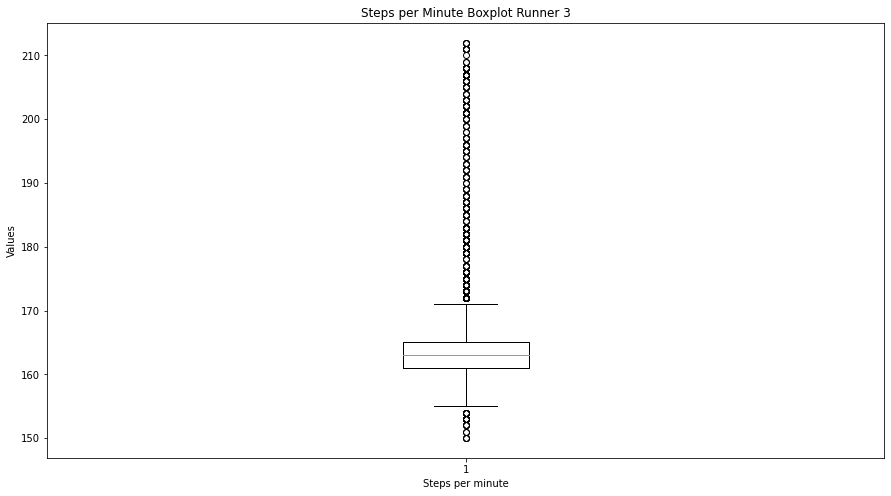

In [246]:
plt.figure(figsize=(15, 8))
plt.boxplot(full_leo['step_sum'])
plt.xlabel('Steps per minute')
plt.ylabel('Values')
plt.title('Steps per Minute Boxplot Runner 3')

In [262]:
box_plot_data = [np.array(full_stefano['step_sum']), np.array(full_juan['step_sum']), np.array(full_leo['step_sum'])]

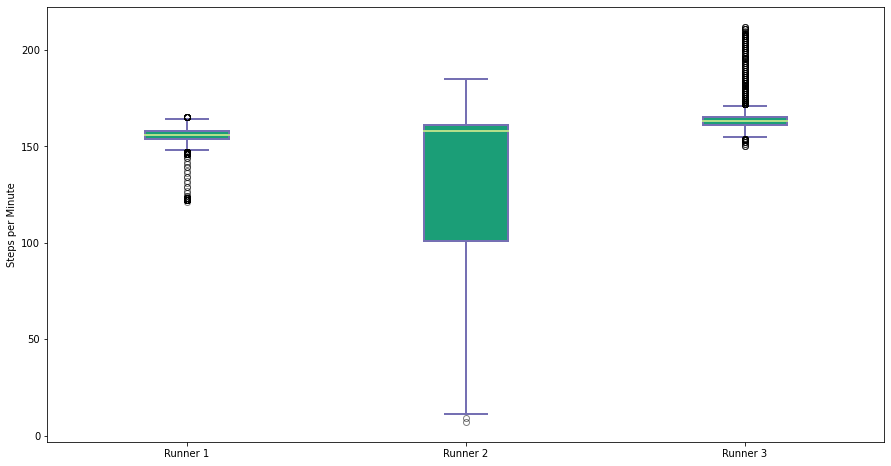

In [268]:
# Create a figure instance
fig = plt.figure(1, figsize=(15, 8))

# Create an axes instance
ax = fig.add_subplot(111)

# Create the boxplot
bp = ax.boxplot(box_plot_data, patch_artist=True)

## change outline color, fill color and linewidth of the boxes
for box in bp['boxes']:
    # change outline color
    box.set( color='#7570b3', linewidth=2)
    # change fill color
    box.set( facecolor = '#1b9e77' )

## change color and linewidth of the whiskers
for whisker in bp['whiskers']:
    whisker.set(color='#7570b3', linewidth=2)

## change color and linewidth of the caps
for cap in bp['caps']:
    cap.set(color='#7570b3', linewidth=2)

## change color and linewidth of the medians
for median in bp['medians']:
    median.set(color='#b2df8a', linewidth=2)

## change the style of fliers and their fill
for flier in bp['fliers']:
    flier.set(marker='o', color='#e7298a', alpha=0.5)
    
ax.set_xticklabels(['Runner 1', 'Runner 2', 'Runner 3'])
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()
ax.set_ylabel('Steps per Minute')

# Save the figure
fig.savefig('boxplot.png', bbox_inches='tight')

In [ ]:
full9.to_csv('juan_1_step_per_min.csv')

In [ ]:
full9.shape

In [244]:
full_juan = pd.read_csv('juan_1_step_per_min.csv', index_col=['timestamp'])
full_stefano = pd.read_csv('stefano_1_step_per_min.csv', index_col=['timestamp'])
full_leo = pd.read_csv('leo_1_step_per_min.csv', index_col=['timestamp'])
#full2 = pd.read_csv('juan_2.csv')
#full5 = pd.read_csv('juan_5.csv')

In [247]:
features = full_juan.columns.to_list()[36:]

In [248]:
full_juan = full_juan[features]
full_stefano = full_stefano[features]
full_leo = full_leo[features]

## Modelling

### Regression

In [249]:
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import Lasso, LogisticRegression, RidgeClassifier, PoissonRegressor, Ridge
from xgboost import XGBClassifier, XGBRegressor, plot_importance
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, f1_score, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.mixture import GaussianMixture
from sklearn.svm import SVR

In [307]:
# Poisson Regressor
params_grid_PO = {
    'alpha':[0, 0.001, 0.01, 0.1, 0.5, 1, 5, 10, 50],
    'max_iter': [10000],
    'verbose':[3]}

# Logistic Regression
params_grid_LR = {
    'penalty':['l1', 'l2', 'elasticnet'],
    'C':[0.001, 0.01, 0.5, 1, 10, 50],
    'solver': ['saga'],
    'max_iter': [10000],
    'n_jobs': [-1], 
    'verbose':[3]}

# Ridge Regression
params_grid_RI = {
    'alpha':[0.0001, 0.01, 0.1, 0.25, 0.5, 1, 5, 10, 20, 50, 100]}

# GradientBoosting Regressor
params_grid_XG = {
    'max_depth':[3, 6, 9, 20],
    'min_child_weight':[1],
    'learning_rate': [0.01, 0.1, 0.2, 0.5],
    'n_jobs':[-1]}

# NaiveBayes
params_grid_NB = {}

# Mixture of Gaussians
params_grid_MoG = {'n_components':[1, 2, 3, 4, 5],
                   'max_iter':[10000],
                   'covariance_type':['tied'],
                   'verbose':[3]}

# Random Forest
params_grid_RF = {'n_estimators':[10, 50, 100, 200],
                   'max_depth':[3, 6, 9, 12],
                   'min_samples_split':[2, 4, 6],
                   'max_features':['auto', 'sqrt', 'log2'],
                   'n_jobs':[-1],
                   'verbose':[3]}

# Support Vector
params_grid_SVR = {'kernel':['linear', 'poly', 'rbf', 'sigmoid'],
                   'degree':[1, 2, 3, 4, 5],
                   'C':[0.001, 0.5, 1, 50],
                   'max_iter':[10000]}

In [308]:
def grid_search(estimator, params, X, y, n_folds=3):
    """
    Grid search for the estimator in input.
    """
   
    gs = GridSearchCV(estimator, params, cv=n_folds, n_jobs=-1, scoring='neg_root_mean_squared_error')
   
    print(f'>> Start grid search on {type(estimator).__name__}')
    try:
        gs.fit(X['train'], y['train'])
    except:
        return (type(estimator).__name__, {},0,0)
   
    y_pred = gs.best_estimator_.predict(X['test'])
   
    res_tuple = (
        str(type(estimator).__name__),
        gs.best_params_,
        -gs.best_score_,
        mean_squared_error(y_test, y_pred, squared=False),
        #accuracy_score(encode_y_test, y_pred),
        #f1_score(encode_y_test, y_pred, average='weighted')
    )
    return res_tuple

In [309]:
full_df = {'stefano':full_stefano, 'juan':full_juan, 'leo':full_leo}

In [310]:
# res_list = []
for key, df in full_df.items():  
    print(key)
    train_set, test_set = train_test_split(df, test_size=0.3, random_state=42)
    X_train = train_set.drop(['step_sum'], axis=1)
    y_train = train_set.step_sum
    X_test = test_set.drop(['step_sum'], axis=1)
    y_test = test_set.step_sum 

    X = {'train':X_train, 'test':X_test}
    y = {'train':y_train, 'test':y_test}

    classifiers = {'PO': PoissonRegressor,
                   'RI':Ridge,
                   'MoG':GaussianMixture,
                   'XG':XGBRegressor,
                   'LR':LogisticRegression,
                   'NB': GaussianNB,
                   'RF': RandomForestRegressor,
                   'SVR': SVR}
    params_grids = {'PO': params_grid_PO,
                    'RI':params_grid_RI,
                    'MoG':params_grid_MoG,
                    'XG':params_grid_XG,
                    'LR':params_grid_LR,
                    'NB': params_grid_NB,
                    'RF': params_grid_RF,
                    'SVR': params_grid_SVR}

    for cls_id in classifiers.keys():
        
        if (key == 'stefano') | (key == 'juan'):
            continue
       
        res = grid_search(classifiers[cls_id](), params_grids[cls_id], X, y, n_folds=5)
        res_list.append([key] + list(res))
        print(res)
    
res_df = pd.DataFrame(res_list, columns=['Who', 'Estimator', 'Best_params', 
                                         'Train_score', 'Test_score'])

stefano
juan
leo
>> Start grid search on XGBRegressor
('XGBRegressor', {'learning_rate': 0.2, 'max_depth': 9, 'min_child_weight': 1, 'n_jobs': -1}, 2.73348562701538, 2.561130254223128)


In [311]:
res_df

,Who,Estimator,Best_params,Train_score,Test_score
0,stefano,PoissonRegressor,"{'alpha': 5, 'max_iter': 10000, 'verbose': 3}",2.455451,2.428268
1,stefano,Ridge,{'alpha': 100},2.451664,2.434540
2,stefano,GaussianMixture,"{'covariance_type': 'tied', 'max_iter': 10000,...",154.009039,153.885266
3,stefano,XGBRegressor,"{'learning_rate': 0.2, 'max_depth': 9, 'min_ch...",1.776475,1.697319
4,stefano,GaussianNB,{},5.146790,4.937871
5,stefano,RandomForestRegressor,"{'max_depth': 12, 'max_features': 'sqrt', 'min...",1.926537,1.872597
6,juan,PoissonRegressor,"{'alpha': 0.1, 'max_iter': 10000, 'verbose': 3}",24.311552,21.883437
7,juan,Ridge,{'alpha': 1},22.146042,21.228571
8,juan,GaussianMixture,"{'covariance_type': 'tied', 'max_iter': 10000,...",140.500047,141.628567
9,juan,XGBRegressor,"{'learning_rate': 0.2, 'max_depth': 6, 'min_ch...",13.942842,12.764406


In [313]:
res_df.to_csv('results_regression_final.csv')

In [10]:
train_set, test_set = train_test_split(full_stefano, test_size=0.3, random_state=42)
X_train = train_set.drop(['step_sum'], axis=1)
y_train = train_set.step_sum
X_test = test_set.drop(['step_sum'], axis=1)
y_test = test_set.step_sum 

X = {'train':X_train, 'test':X_test}
y = {'train':y_train, 'test':y_test}

In [26]:
ri = Ridge(**res_list[0][2])

TypeError: __init__() got an unexpected keyword argument 'verbose'

In [83]:
ri.fit(X['train'], y['train'])

Ridge(alpha=100)

In [84]:
y_pred = ri.predict(X['test'])

In [85]:
test = pd.DataFrame()
test['pred'] = y_pred
test['true'] = np.array(y['test'])

In [25]:
test.head(50)

NameError: name 'test' is not defined

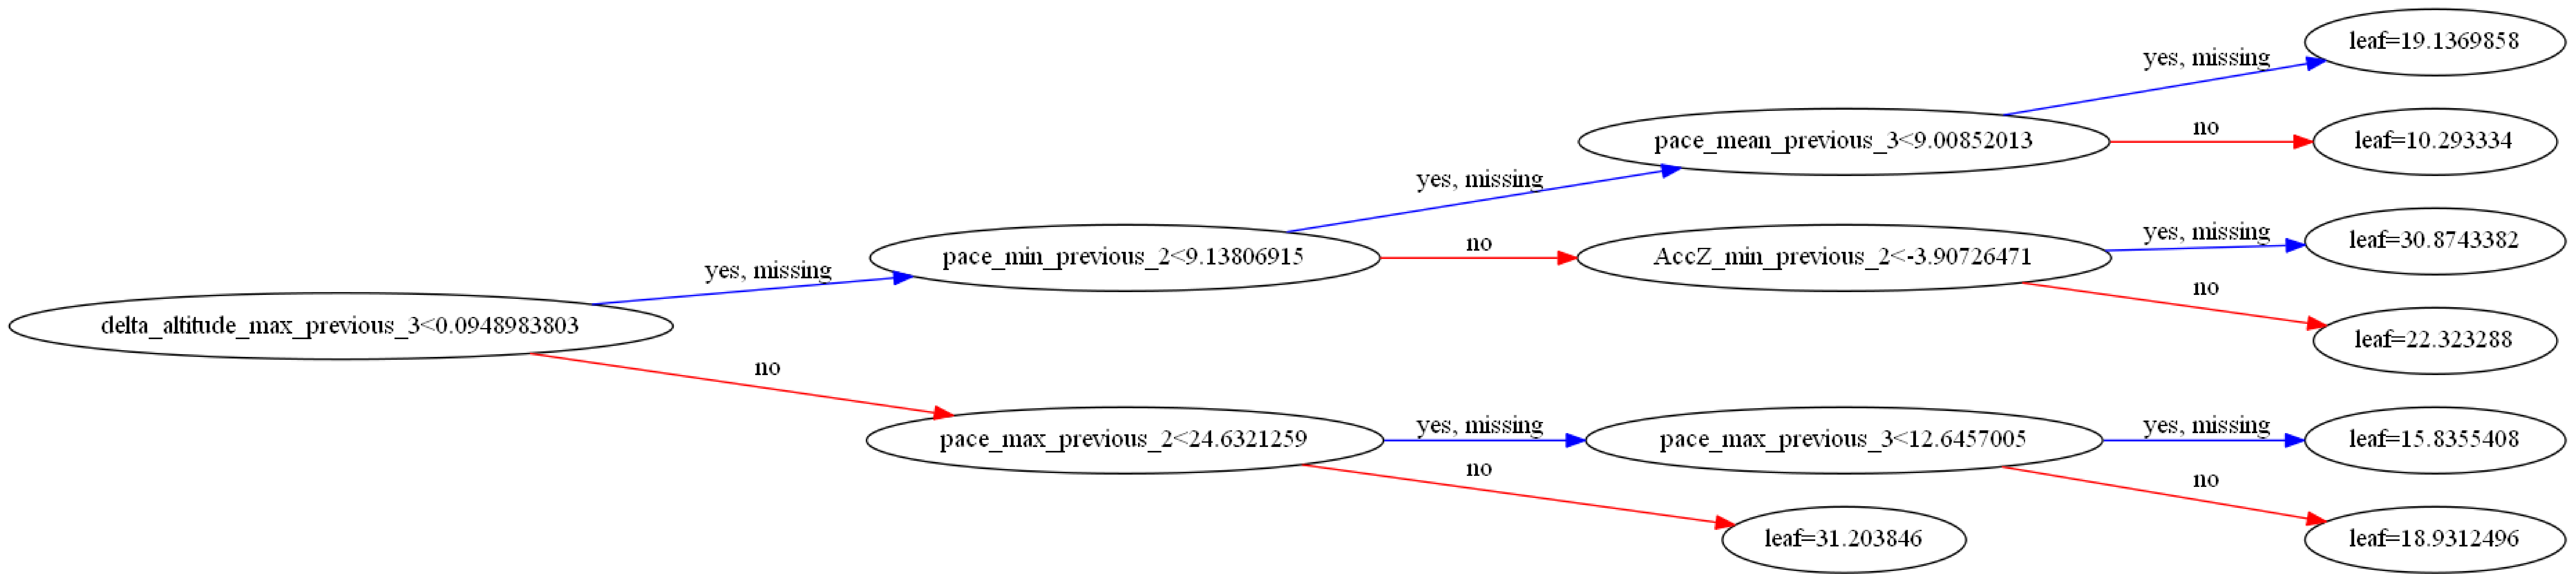

In [33]:
from xgboost import plot_tree
import matplotlib.pyplot as plt
plot_tree(xgb, rankdir='LR')
fig = plt.gcf()
fig.set_size_inches(150, 100)
fig.savefig('tree.png')

In [34]:
y_pred = xgb.predict(X['test'])

In [38]:
test = pd.DataFrame()
test['pred'] = y_pred
test['true'] = np.array(y['test'])

In [39]:
test

,pred,true
0,81.560295,80.0
1,159.743561,158.0
2,164.301758,162.0
3,114.474937,115.0
4,133.608002,157.0
...,...,...
1840,87.135010,85.0
1841,152.386902,95.0
1842,166.445145,164.0
1843,148.228790,143.0


In [37]:
y['test']

5636     80.0
2330    158.0
3226    162.0
3012    115.0
5152    157.0
        ...  
3424     85.0
4386     95.0
620     164.0
4404    143.0
4250    157.0
Name: step_sum, Length: 1845, dtype: float64

### Classification

In [ ]:
from datetime import datetime
import pandas as pd
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import mean_squared_error, accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [ ]:
def grid_search(estimator, params, X, y, n_folds=3):
    """
    Grid search for the estimator in input.
    """

   
    gs = GridSearchCV(estimator, params, cv=n_folds, n_jobs=-1, 
                    verbose=4, scoring='neg_root_mean_squared_error')
   
    print(f'>> Start grid search on {type(estimator).__name__}')
    try:
        gs.fit(X['train'], y['train'])
    except:
        return (type(estimator).__name__, {},0,0)
   
    y_pred = gs.best_estimator_.predict(X['test'])
   
    res_tuple = (
        str(type(estimator).__name__),
        gs.best_params_,
        -gs.best_score_,
        mean_squared_error(y['test'], y_pred, squared=False),
        accuracy_score(y['test'], y_pred),
        f1_score(y['test'], y_pred, average='weighted')
    )
    return res_tuple

In [ ]:
# Gaussian Naive Bayes
params_grid_NB = {}


# Random Forest
params_grid_RF = {
    'n_estimators':[100,200],
    'criterion':['gini','entropy'],
    'max_depth':[20,30,100],
    'n_jobs':[-1],
    'class_weight':['balanced'],
    'random_state':[42]
    }


# SVM
params_grid_SVM = {
    'C':[1, 10],
    'kernel':['linear', 'rbf'],
    'class_weight':['balanced'],
    'max_iter':[10000],
    'random_state':[42]
    }


# Logistic Regression
params_grid_LR = {
    'penalty':['l2', 'elasticnet'],
    'C':[0.01, 0.5, 1],
    'solver': ['saga'],
    'max_iter': [10000],
    'n_jobs': [-1], 
    'random_state':[42]
}

    
#Ridge Classifier
params_grid_RI = {
    'alpha':[0.0001, 0.01, 0.1, 0.25, 0.5, 1, 5, 10, 20, 50],
    'class_weight':['balanced'],
    'random_state':[42]
}


# GradientBoostingClassifier
params_grid_XG = {
    'max_depth':[6, 9, 20],
    'min_child_weight':[1],
    'learning_rate': [0.03, 0.1, 0.5],
    'n_jobs':[-1],
    'tree_method':['gpu_hist'],
    'random_state':[42],
    'use_label_encoder':[False]
}

In [ ]:
res_list = []

for key, df in full_df.items():  
   
    le = LabelEncoder()
    le.fit(df['step_sum'])
    train_set, test_set = train_test_split(df, test_size=0.3, random_state=42)
    X_train = train_set.drop(['step_sum'], axis=1)
    y_train = le.transform(train_set.step_sum)
    X_test = test_set.drop(['step_sum'], axis=1)
    y_test = le.transform(test_set.step_sum )

    X = {'train':X_train, 'test':X_test}
    y = {'train':y_train, 'test':y_test}

    classifiers = {'RI':RidgeClassifier,
                   'XG':XGBClassifier,
                   'LR':LogisticRegression,
                   'RF':RandomForestClassifier, 
                   'NB':GaussianNB,
                   'SVM':SVC
                  }
    params_grids = {'RI':params_grid_RI,
                    'XG':params_grid_XG,
                    'LR':params_grid_LR,
                    'RF':params_grid_RF, 
                    'NB':params_grid_NB,
                    'SVM':params_grid_SVM
                   }


    for cls_id in classifiers.keys():
        res = grid_search(classifiers[cls_id](), params_grids[cls_id], X, y, n_folds=5)
        res_list.append([key] + list(res))
    
res_df = pd.DataFrame(res_list, columns=['df', 'Estimator', 'Best_params', 'Train_score', 
                                         'Test_score', 'Test_accuracy', 'Test_F1'])

In [ ]:
res_df.to_csv(f'../results/results_classification_{datetime.now()}.csv', index=False)

### Model Interpretability

We will assume that the models we will use for interpretability means are the Poisson Regressor and the Random Forest

#### Random Forest

In [291]:
def get_rf_top(rf, features, top=10, save_name='R'):
    
    rf_list = rf.feature_importances_
    forest_importances = pd.Series(rf_list, index=features).sort_values(ascending=False)[:top]
    fig, ax = plt.subplots()
    forest_importances.plot.bar(ax=ax, figsize=(15, 8))
    ax.set_title("Feature importances using MDI")
    ax.set_ylabel("Mean decrease in impurity")
    fig.tight_layout()
    fig.savefig(save_name)
    return forest_importances.index.to_list()

In [ ]:
from treeinterpreter import treeinterpreter as ti

def explain_prediction(row, model=rf, top=10, plot=True, save_name='R'):
    """ This function will allow us to understand the variables that have contributed to each prediction """
    
    preds, bias, contributions = ti.predict(rf, row)
    df_contr = pd.DataFrame()
    df_contr['contribution'] = abs(contributions[0])
    df_contr['feature'] = row.columns.to_list()
    
    df_contr.sort_values(by='contribution', ascending=False, inplace=True)
    if plot:
        df_contr[:top].sort_values(by='contribution', ascending=True).plot.barh(y='contribution', x='feature')
        plt.xlabel('Contribution to Prediction')
        plt.ylabel('Feature Name')
        plt.title(f'Explaining Prediction {round(preds[0][0], 2)}')
        plt.savefig(save_name)
        plt.show()
            
    return df_contr   

<br><br>

#### Poisson Regressor

In [ ]:
from numpy import asarray
from sklearn.preprocessing import StandardScaler

In [ ]:
def variable_importance_poisson(runner, poisson_params, save_name, top=10):
    
    names_dict = {'stefano': 'Runner 1',
                'juan': 'Runner 2',
                'leo': 'Runner 3'}
    
    df = full_df[runner]
    
    st_df = df.drop('step_sum', axis=1)
    
    scaler = StandardScaler()
    # transform data
    scaled = scaler.fit_transform(st_df)
    scaled = pd.DataFrame(scaled, columns=st_df.columns.to_list())
    scaled['step_sum'] = df.step_sum.to_list()
    
    train_set, test_set = train_test_split(scaled, test_size=0.3, random_state=42)
    X_train = train_set.drop(['step_sum'], axis=1)
    y_train = train_set.step_sum
    X_test = test_set.drop(['step_sum'], axis=1)
    y_test = test_set.step_sum 

    X = {'train':X_train, 'test':X_test}
    y = {'train':y_train, 'test':y_test}
    
    po = PoissonRegressor(**poisson_params)
    
    po.fit(X['train'], y['train'])
    
    imp_po = pd.DataFrame()
    imp_po['abs_coef'] = abs(po.coef_)
    imp_po['name'] = X['train'].columns.to_list()
    
    imp_po.sort_values(by='abs_coef', ascending=False, inplace=True)
    
    imp_po[:top].sort_values(by='abs_coef', ascending=True).plot.barh(y='abs_coef', x='name',
                                                                     figsize=(15,8))
    plt.xlabel('Absolute Coefficient Value')
    plt.ylabel('Coefficient Name')
    plt.title(f'Variable Importance {names_dict[runner]}')
    plt.savefig(save_name)
    plt.show() 
    
    return imp_po['name'].to_list()[:top]

<br><br>

### LOCO Implementation

In [362]:
from scipy.stats import norm

def LOCO(model, params, runner, top_features, save_name):
    """ top features is a list of the most important features """
    
    names_dict = {'stefano': 'Runner 1',
                  'juan': 'Runner 2',
                  'leo': 'Runner 3'}
    
    df = full_df[runner]
    
    train_set, test_set = train_test_split(df, test_size=0.3, random_state=42)
    X_train = train_set.drop(['step_sum'], axis=1)
    y_train = train_set.step_sum
    X_test = test_set.drop(['step_sum'], axis=1)
    y_test = test_set.step_sum 

    X = {'train':X_train, 'test':X_test}
    y = {'train':y_train, 'test':y_test}
    
    md = model(**params)
    md.fit(X['train'], y['train'])
    
    y_pred_full = md.predict(X['test'])
    
    red_models = {}
    for var in top_features:
        print(f'>> Removing Variable {var} when modelling')
        tmp_df = X['train'].drop(var, axis=1)
        md_red = model(**params)
        md_red.fit(tmp_df, y['train'])
        
        red_models[var] = md_red
        
    B = 1000
    median_sd_boot = {}
    median_true = {}
    
    for var in top_features:
        print(f'>> Boostrap over Variable {var}')
        df_red = X['test'].drop(var, axis=1)
        y_pred_red = red_models[var].predict(df_red)
        
        delta_error = abs(y['test'] - y_pred_red) - abs(y['test'] - y_pred_full)
        median_true[var] = np.median(delta_error)
        
        median_list_boot = []
        for b in range(B):
            idx = np.random.choice(list(range(len(df_red))), size=len(df_red), replace=True)
            
            boost_df = df_red.iloc[idx]
            boost_target = y['test'].iloc[idx]
            
            y_pred_boost = red_models[var].predict(boost_df)
            y_pred_boost_full = y_pred_full[idx]
            
            median_list_boot.append(np.median(abs(boost_target - y_pred_boost) - 
                                              abs(boost_target - y_pred_boost_full)))
        median_sd_boot[var] = np.std(median_list_boot)
        
    alpha = 0.05/len(top_rf_stefano[:5])

    CI_list = []
    for key, value in median_sd_boot.items():
        CI_up = median_true[key] - norm.ppf(1-alpha/2)*value
        CI_low = median_true[key] + norm.ppf(1-alpha/2)*value
        CI_list.append(CI_up-CI_low)

    x = top_features
    y = list(median_true.values())
    e = CI_list
    plt.figure(figsize=(15, 8))
    plt.errorbar(x, y, yerr=e, fmt='o')
    plt.ylabel('Median Error on Prediction')
    plt.xlabel('Variable Removed')
    plt.title(f'LOCO Analysis for {names_dict[runner]}')
    plt.xticks(rotation=45)
    plt.show()
    plt.savefig(save_name)
    
    return median_true, median_sd_boot

### Decision tree visualization

In [ ]:
from sklearn.tree import export_graphviz
from xgboost import XGBRegressor, plot_tree
import matplotlib.pyplot as plt
from dtreeviz.trees import *
from dtreeviz.models.xgb_decision_tree import ShadowXGBDTree

plt.style.use('seaborn')

In [ ]:
def visualize_decision_tree(model, X, y, tree_idx=0, 
                            save_path='../assets/tree_test.svg',
                            std_graph_fun=False,
                            figsize=(18,10), 
                            max_depth=3, 
                            show_pred=True,
                            show_just_path=False, 
                            orientation='LR'):
    """
    Visualize the decision tree and save the image
    
    :param model: either a RandomForestRegressor or a XGBoost instance
    :param X: training data
    :param y: training target
    :param tree_idx: index of the tree to be plotted; usually shallower trees have the lowest indices
    :param save_path: path name for the output file; pay attention on the extension of the file:
                    .dot or .png (if XGBoost) if std_graph_fun else .svg
    :param std_graph_fun (graphic): whether use the standard library built-in
                          function (export_graphviz or plot_tree) or deepviz
    :param figsize (graphic): figure size of the image; used only with XGBoost 
                              and std_graph_fun=True, ignored otherwise
    :param max_depth (graphic): max depth of the tree; only for export_graphviz
    :param show_pred (graphic): show the prediction path; only deepviz
    :param show_just_path (graphic): don't display the entire tree; only deepviz
    :param orientation (graphic): left-right (default) or top-down
    
    :return 
    """
    
    feature_names = X.columns.to_list()
    
    if show_pred:
        target_idx = y.index[y > 130][0]
        x_to_pred = X.loc[target_idx,].to_numpy()
    else:
        x_to_pred = None
    
    if isinstance(model, RandomForestRegressor):
        if std_graph_fun:
            estimator = rf.estimators_[tree_idx] 
            export_graphviz(estimator, out_file=save_path, feature_names=feature_names,
                            rounded=True, proportion=False, precision=2, filled=True, 
                            max_depth=max_depth, rotate=orientation)
        else:
            viz = dtreeviz(estimator, X, y,
                           target_name='step_sum', feature_names=feature_names, 
                           X=x_to_pred, show_just_path=show_just_path,
                           orientation=orientation)
            viz.save(save_path)
    else:
        if std_graph_fun:
            plt.figure(figsize=figsize)
            ax = plt.axes()
            plot_tree(xgb, num_trees=tree_idx, ax=ax)
            plt.savefig(save_path)
            plt.show()
        else:
            xgb_shadow = ShadowXGBDTree(model, tree_idx, X.sample(), y, 
                                        target_name='step_sum', feature_names=feature_names)
            viz = dtreeviz(xgb_shadow, orientation=orientation, 
                           X=x_to_pred, show_just_path=show_just_path)
            viz.save(save_path)
    

### LIME Implementation

In [ ]:
import lime
import lime.lime_tabular

In [365]:
def visualize_decision_tree(model, X, y, tree_idx=0,
                            save_path='../assets/tree_test.svg',
                            std_graph_fun=False,
                            figsize=(18,10),
                            max_depth=3,
                            show_pred=True,
                            show_just_path=False,
                            orientation='LR'):
    """
    Visualize the decision tree and save the image
   
    :param model: either a RandomForestRegressor or a XGBoost instance
    :param X: training data
    :param y: training target
    :param tree_idx: index of the tree to be plotted; usually shallower trees have the lowest indices
    :param save_path: path name for the output file; pay attention on the extension of the file:
                    .dot or .png (if XGBoost) if std_graph_fun else .svg
    :param std_graph_fun (graphic): whether use the standard library built-in
                          function (export_graphviz or plot_tree) or deepviz
    :param figsize (graphic): figure size of the image; used only with XGBoost
                              and std_graph_fun=True, ignored otherwise
    :param max_depth (graphic): max depth of the tree; only for export_graphviz
    :param show_pred (graphic): show the prediction path; only deepviz
    :param show_just_path (graphic): don't display the entire tree; only deepviz
    :param orientation (graphic): left-right (default) or top-down
   
    :return
    """
   
    feature_names = X.columns.to_list()
   
    if show_pred:
        target_idx = y.index[y > 130][0]
        x_to_pred = X.loc[target_idx,].to_numpy()
    else:
        x_to_pred = None
   
    if isinstance(model, RandomForestRegressor):
        if std_graph_fun:
            estimator = rf.estimators_[tree_idx]
            export_graphviz(estimator, out_file=save_path, feature_names=feature_names,
                            rounded=True, proportion=False, precision=2, filled=True,
                            max_depth=max_depth, rotate=orientation)
        else:
            viz = dtreeviz(estimator, X, y,
                           target_name='step_sum', feature_names=feature_names,
                           X=x_to_pred, show_just_path=show_just_path,
                           orientation=orientation)
            viz.save(save_path)
    else:
        if std_graph_fun:
            plt.figure(figsize=figsize)
            ax = plt.axes()
            plot_tree(xgb, num_trees=tree_idx, ax=ax)
            plt.savefig(save_path)
            plt.show()
        else:
            xgb_shadow = ShadowXGBDTree(model, tree_idx, X.sample(), y,
                                        target_name='step_sum', feature_names=feature_names)
            viz = dtreeviz(xgb_shadow, orientation=orientation,
                           X=x_to_pred, show_just_path=show_just_path)
            viz.save(save_path)

In [366]:
def visualize_lime(model, X, x, y, num_features=10, save_path='../assets/lime_test_2.html', 
                   show_table=True, to_pyplot=False):
    """
    Visualize the LIME explaination and save the image
    
    :param model: model that implements the predict() method
    :param X: test data
    :param x: one test observation
    :param y: observation ground truth
    :param num_features: number of features to display
    :param save_path: path name for the output file
    :param show_table: show the features table (html only)
    :param to_pyplot: convert to pyplot
    
    :return
    """
    
    explainer = lime.lime_tabular.LimeTabularExplainer(X.to_numpy(), mode='regression',
                                                    feature_names=X.columns.to_list(), 
                                                    class_names=['step_sum'], 
                                                    discretize_continuous=True, 
                                                    verbose=True)
    print('>> Explaining the following prediction')
    print(f'Step_sum value: {y}')
    exp = explainer.explain_instance(x, model.predict, num_features=num_features)
    if to_pyplot:
        plt.style.use('seaborn')
        plt.rcParams['xtick.labelsize'] = 'medium'
        plt.rcParams['ytick.labelsize'] = 'medium'
        plt.rcParams['axes.titlesize'] = 'large'
        plt.rcParams['figure.figsize'] = (20, 13)
        fig = exp.as_pyplot_figure()
        fig.savefig(save_path, bbox_inches="tight")
    else:
        exp.save_to_file(save_path)
    return exp

<br><br>

### Wrapper

In [363]:
def interpretability(runner, params_tree, params_po):
    
    names_dict = {'stefano': 'Runner 1',
                  'juan': 'Runner 2',
                  'leo': 'Runner 3'}
    
    df = full_df[runner]
    
    train_set, test_set = train_test_split(df, test_size=0.3, random_state=42)
    X_train = train_set.drop(['step_sum'], axis=1)
    y_train = train_set.step_sum
    X_test = test_set.drop(['step_sum'], axis=1)
    y_test = test_set.step_sum
    
    ### XGBRegressor
    rf = XGBRegressor(**params_tree)
    rf.fit(X['train'], y['train'])
    
    ### Poisson regressor
    po = PoissonRegressor(**params_po)
    po.fit(X_train, y_train)
    
    print('>> Get Top variable Tree')
    top_rf = get_rf_top(rf, X['train'].columns.to_list(), save_name='Images/' + names_dict[runner] + ' top features Tree.png')
    
    print('>> Explain Predictions Tree')
    for i in [300, 1500, 3500]:
        df_xg = explain_prediction(X['test'][i:i+1], model=rf, 
                                   save_name='Images/' + names_dict[runner] + ' top features Tree' + str(i) + '.png')
        
    print('>> LOCO Tree')
    LOCO(XGBRegressor, params_tree, runner, top_rf, 
         save_name='Images/' + names_dict[runner] + ' LOCO Tree.png')
    
    ### Poisson Regressor  
    print('>> Get Top variable Poisson')
    top_poisson = variable_importance_poisson(runner, params_po, 
                                              save_name='Images/' + names_dict[runner] + ' top features Poisson.png')
    
    print('>> LOCO Poisson')
    LOCO(PoissonRegressor, params_po, runner, top_poisson, 
         save_name='Images/' + names_dict[runner] + ' LOCO Poisson.png')
    
    
    ### Define quantiles and select observation
    q = [.25, .5, .75, 1]
    y_pred = rf.predict(X_test)
    errors = y_pred - y_test
    right_pred_idx = errors.abs().idxmin()
    x_right, y_right = (X_test.loc[right_pred_idx,], y_test.loc[right_pred_idx])
   
    print('>> Visualize tree')
    tree_idx = {'stefano':6,'juan':0,'leo':7}
    visualize_decision_tree(rf, X_train, y_train, tree_idx=tree_idx[runner], 
                            save_path=f'../assets/tree_{runner}.svg', show_pred=False)
   
    print('>> LIME tree')
    exp = visualize_lime(rf, X_test, x_right, y_right, save_path=f'../assets/lime_tree_{runner}.png', 
                         to_pyplot=True)
    top_feat = [exp.as_map()[0][i][0]+1 for i in range(len(exp.as_map()[0]))]
    df[df.columns.to_numpy()[top_feat]].quantile(q).transpose()\
                        .to_latex(f'../results/lime_tree_{runner}.txt')
    
    print('>> LIME Poisson')
    exp = visualize_lime(po, X_test, x_right, y_right, save_path=f'../assets/lime_pois_{runner}.png', 
                         to_pyplot=True)
    top_feat = [exp.as_map()[0][i][0]+1 for i in range(len(exp.as_map()[0]))]
    df[df.columns.to_numpy()[top_feat]].quantile(q).transpose()\
                        .to_latex(f'../results/lime_pois_{runner}.txt')

>> Get Top variable Tree
>> Explain Predictions Tree


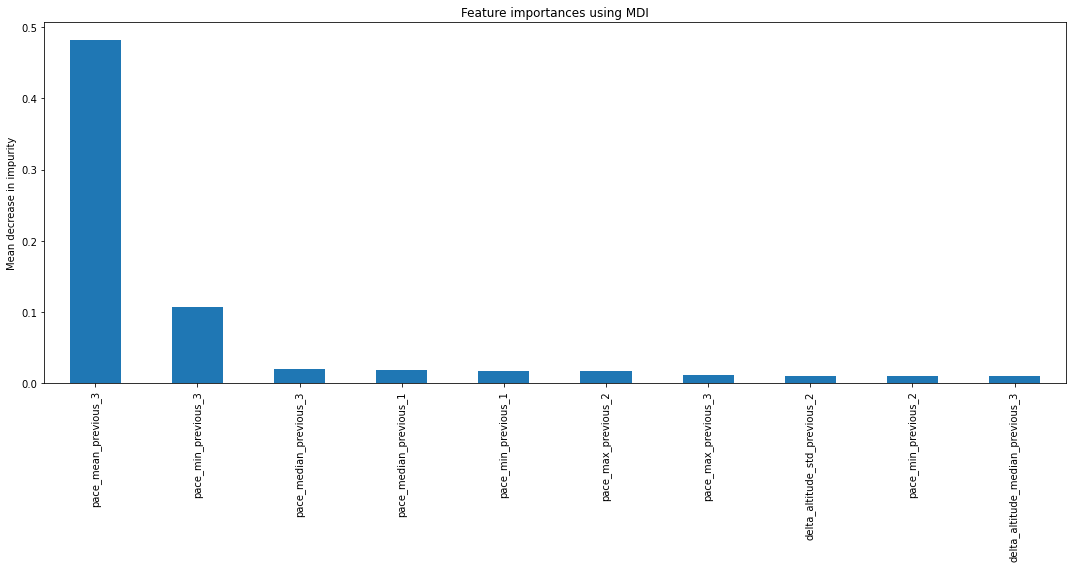

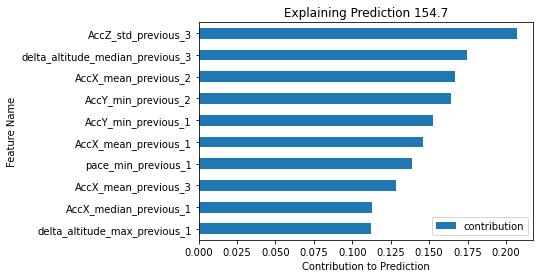

<Figure size 432x288 with 0 Axes>

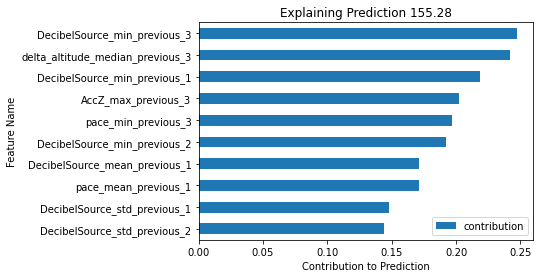

<Figure size 432x288 with 0 Axes>

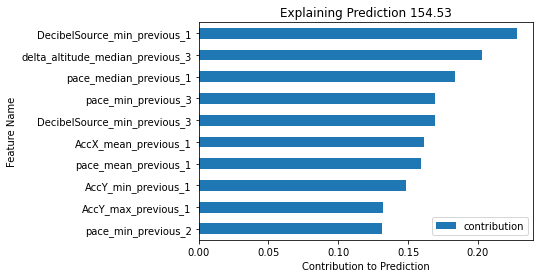

>> LOCO Tree
>> Removing Variable pace_mean_previous_3 when modelling
>> Removing Variable pace_min_previous_3 when modelling
>> Removing Variable pace_median_previous_3 when modelling
>> Removing Variable pace_median_previous_1 when modelling
>> Removing Variable pace_min_previous_1 when modelling
>> Removing Variable pace_max_previous_2 when modelling
>> Removing Variable pace_max_previous_3 when modelling
>> Removing Variable delta_altitude_std_previous_2 when modelling
>> Removing Variable pace_min_previous_2 when modelling
>> Removing Variable delta_altitude_median_previous_3 when modelling
>> Boostrap over Variable pace_mean_previous_3
>> Boostrap over Variable pace_min_previous_3
>> Boostrap over Variable pace_median_previous_3
>> Boostrap over Variable pace_median_previous_1
>> Boostrap over Variable pace_min_previous_1
>> Boostrap over Variable pace_max_previous_2
>> Boostrap over Variable pace_max_previous_3
>> Boostrap over Variable delta_altitude_std_previous_2
>> Boostrap 

<Figure size 432x288 with 0 Axes>

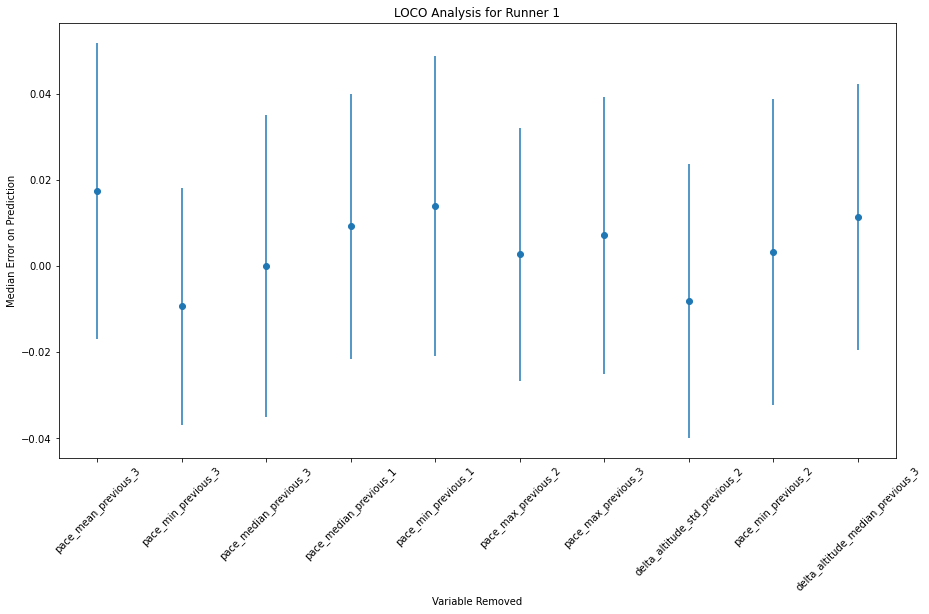

>> Get Top variable Poisson


<Figure size 432x288 with 0 Axes>

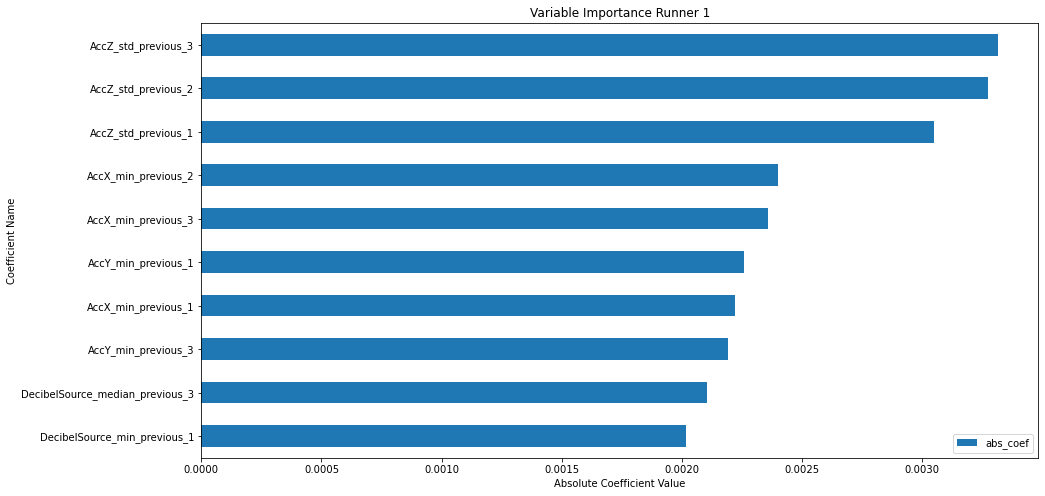

>> LOCO Poisson
>> Removing Variable AccZ_std_previous_3 when modelling
>> Removing Variable AccZ_std_previous_2 when modelling
>> Removing Variable AccZ_std_previous_1 when modelling
>> Removing Variable AccX_min_previous_2 when modelling
>> Removing Variable AccX_min_previous_3 when modelling
>> Removing Variable AccY_min_previous_1 when modelling
>> Removing Variable AccX_min_previous_1 when modelling
>> Removing Variable AccY_min_previous_3 when modelling
>> Removing Variable DecibelSource_median_previous_3 when modelling
>> Removing Variable DecibelSource_min_previous_1 when modelling
>> Boostrap over Variable AccZ_std_previous_3
>> Boostrap over Variable AccZ_std_previous_2
>> Boostrap over Variable AccZ_std_previous_1
>> Boostrap over Variable AccX_min_previous_2
>> Boostrap over Variable AccX_min_previous_3
>> Boostrap over Variable AccY_min_previous_1
>> Boostrap over Variable AccX_min_previous_1
>> Boostrap over Variable AccY_min_previous_3
>> Boostrap over Variable DecibelSo

<Figure size 432x288 with 0 Axes>

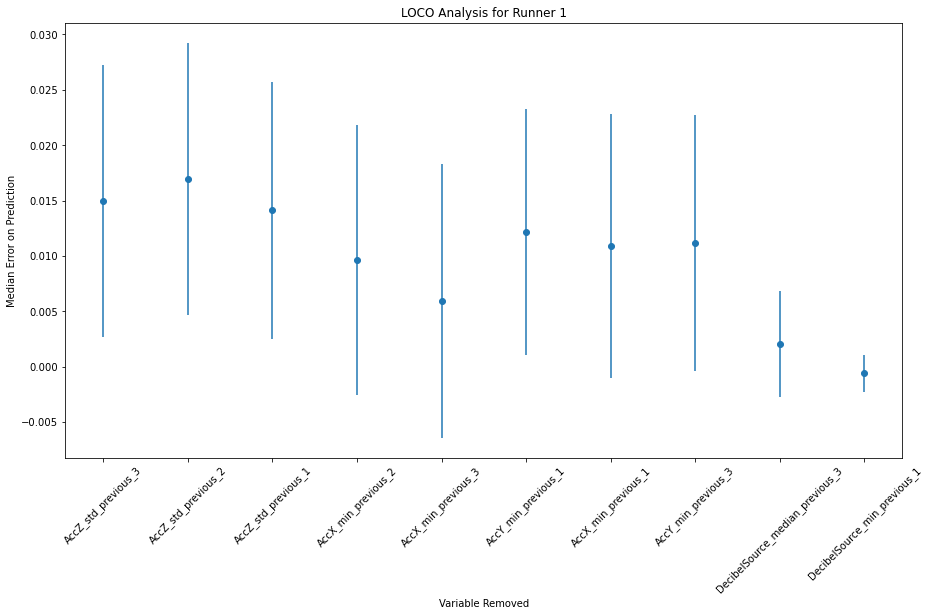

>> Get Top variable Tree
>> Explain Predictions Tree


<Figure size 432x288 with 0 Axes>

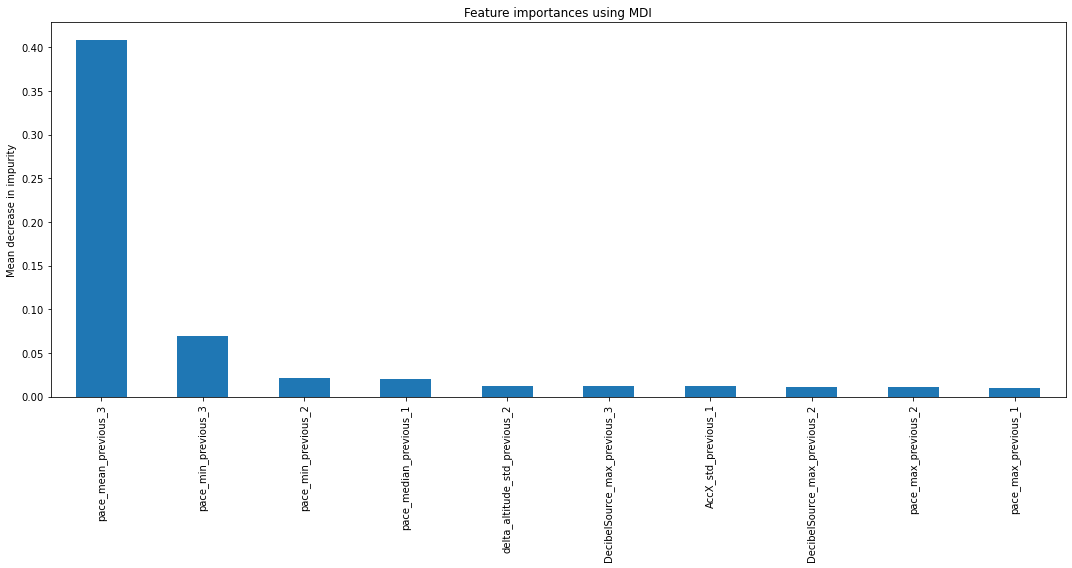

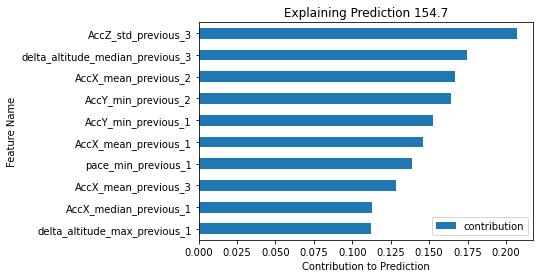

<Figure size 432x288 with 0 Axes>

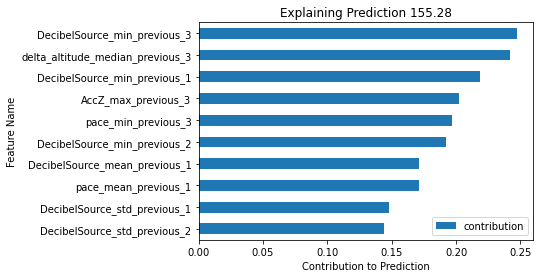

<Figure size 432x288 with 0 Axes>

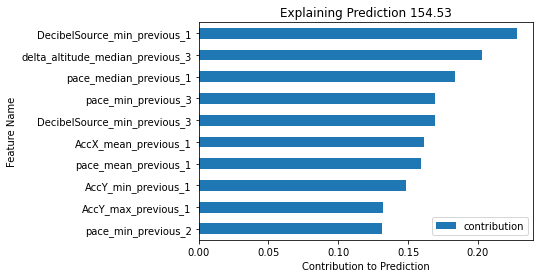

>> LOCO Tree
>> Removing Variable pace_mean_previous_3 when modelling
>> Removing Variable pace_min_previous_3 when modelling
>> Removing Variable pace_min_previous_2 when modelling
>> Removing Variable pace_median_previous_1 when modelling
>> Removing Variable delta_altitude_std_previous_2 when modelling
>> Removing Variable DecibelSource_max_previous_3 when modelling
>> Removing Variable AccX_std_previous_1 when modelling
>> Removing Variable DecibelSource_max_previous_2 when modelling
>> Removing Variable pace_max_previous_2 when modelling
>> Removing Variable pace_max_previous_1 when modelling
>> Boostrap over Variable pace_mean_previous_3
>> Boostrap over Variable pace_min_previous_3
>> Boostrap over Variable pace_min_previous_2
>> Boostrap over Variable pace_median_previous_1
>> Boostrap over Variable delta_altitude_std_previous_2
>> Boostrap over Variable DecibelSource_max_previous_3
>> Boostrap over Variable AccX_std_previous_1
>> Boostrap over Variable DecibelSource_max_previo

<Figure size 432x288 with 0 Axes>

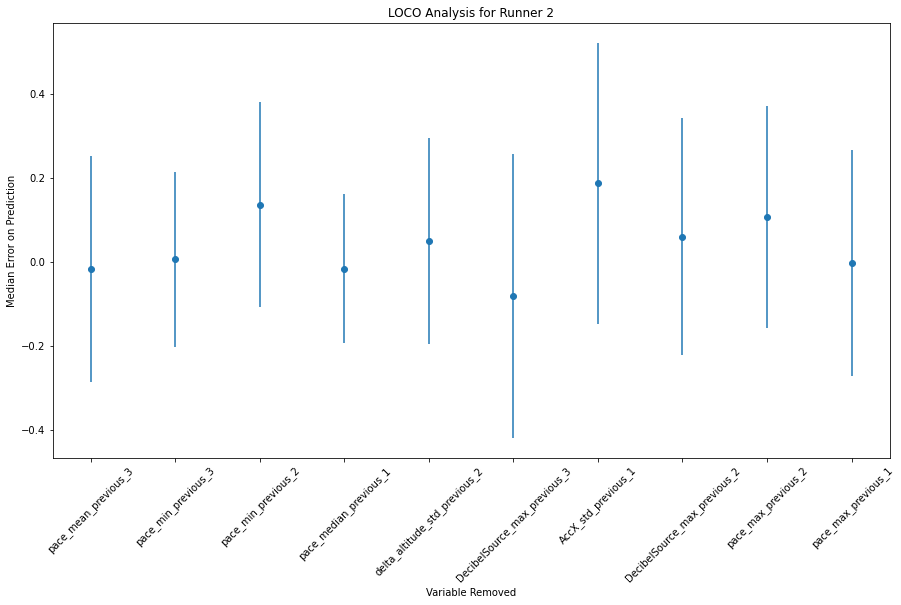

>> Get Top variable Poisson


<Figure size 432x288 with 0 Axes>

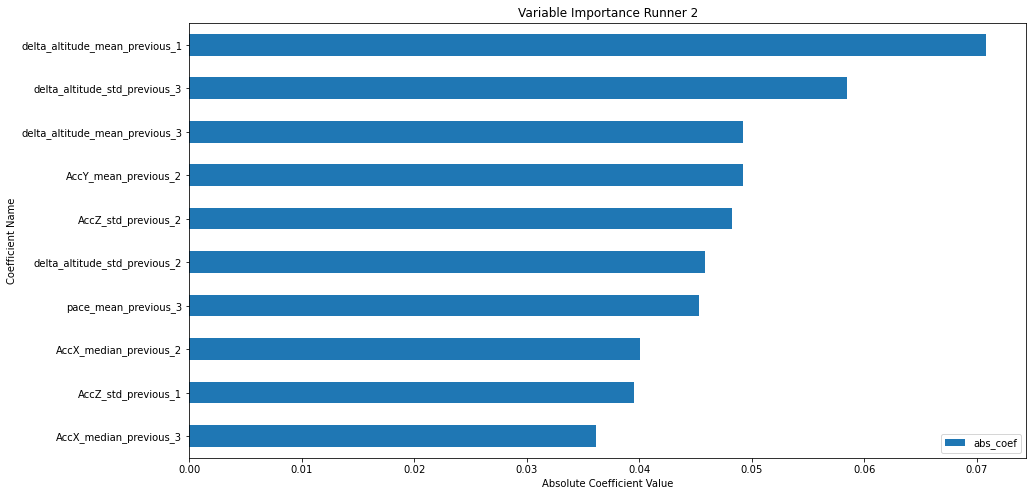

>> LOCO Poisson


C:\Users\juanm\Anaconda3\envs\data_science_general\lib\site-packages\sklearn\linear_model\_glm\glm.py:285: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html



>> Removing Variable delta_altitude_mean_previous_1 when modelling
>> Removing Variable delta_altitude_std_previous_3 when modelling


C:\Users\juanm\Anaconda3\envs\data_science_general\lib\site-packages\sklearn\linear_model\_glm\glm.py:285: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html



>> Removing Variable delta_altitude_mean_previous_3 when modelling


C:\Users\juanm\Anaconda3\envs\data_science_general\lib\site-packages\sklearn\linear_model\_glm\glm.py:285: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html



>> Removing Variable AccY_mean_previous_2 when modelling


C:\Users\juanm\Anaconda3\envs\data_science_general\lib\site-packages\sklearn\linear_model\_glm\glm.py:285: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html



>> Removing Variable AccZ_std_previous_2 when modelling


C:\Users\juanm\Anaconda3\envs\data_science_general\lib\site-packages\sklearn\linear_model\_glm\glm.py:285: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html



>> Removing Variable delta_altitude_std_previous_2 when modelling


C:\Users\juanm\Anaconda3\envs\data_science_general\lib\site-packages\sklearn\linear_model\_glm\glm.py:285: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html



>> Removing Variable pace_mean_previous_3 when modelling
>> Removing Variable AccX_median_previous_2 when modelling


C:\Users\juanm\Anaconda3\envs\data_science_general\lib\site-packages\sklearn\linear_model\_glm\glm.py:285: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html



>> Removing Variable AccZ_std_previous_1 when modelling


C:\Users\juanm\Anaconda3\envs\data_science_general\lib\site-packages\sklearn\linear_model\_glm\glm.py:285: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html



>> Removing Variable AccX_median_previous_3 when modelling


C:\Users\juanm\Anaconda3\envs\data_science_general\lib\site-packages\sklearn\linear_model\_glm\glm.py:285: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html



>> Boostrap over Variable delta_altitude_mean_previous_1
>> Boostrap over Variable delta_altitude_std_previous_3
>> Boostrap over Variable delta_altitude_mean_previous_3
>> Boostrap over Variable AccY_mean_previous_2
>> Boostrap over Variable AccZ_std_previous_2
>> Boostrap over Variable delta_altitude_std_previous_2
>> Boostrap over Variable pace_mean_previous_3
>> Boostrap over Variable AccX_median_previous_2
>> Boostrap over Variable AccZ_std_previous_1
>> Boostrap over Variable AccX_median_previous_3


<Figure size 432x288 with 0 Axes>

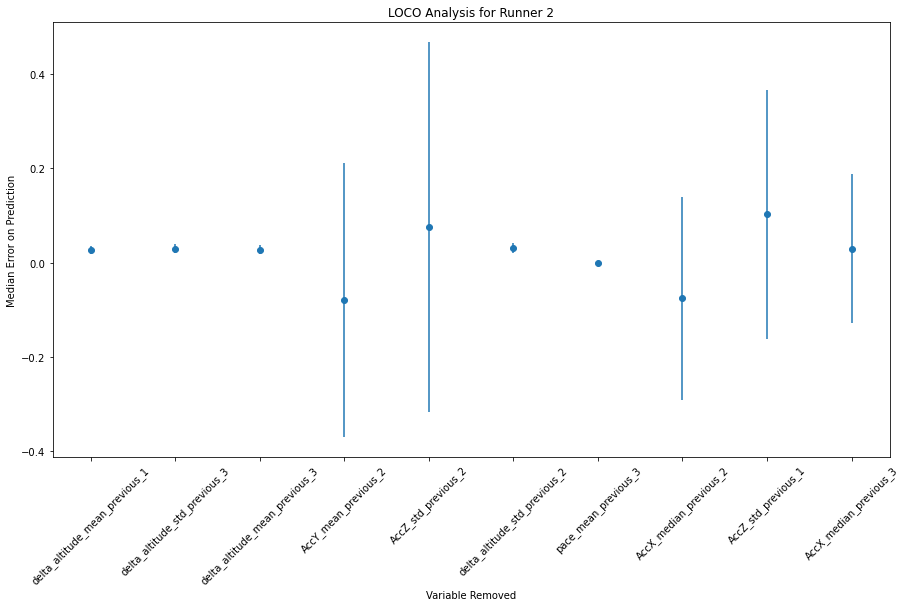

>> Get Top variable Tree
>> Explain Predictions Tree


<Figure size 432x288 with 0 Axes>

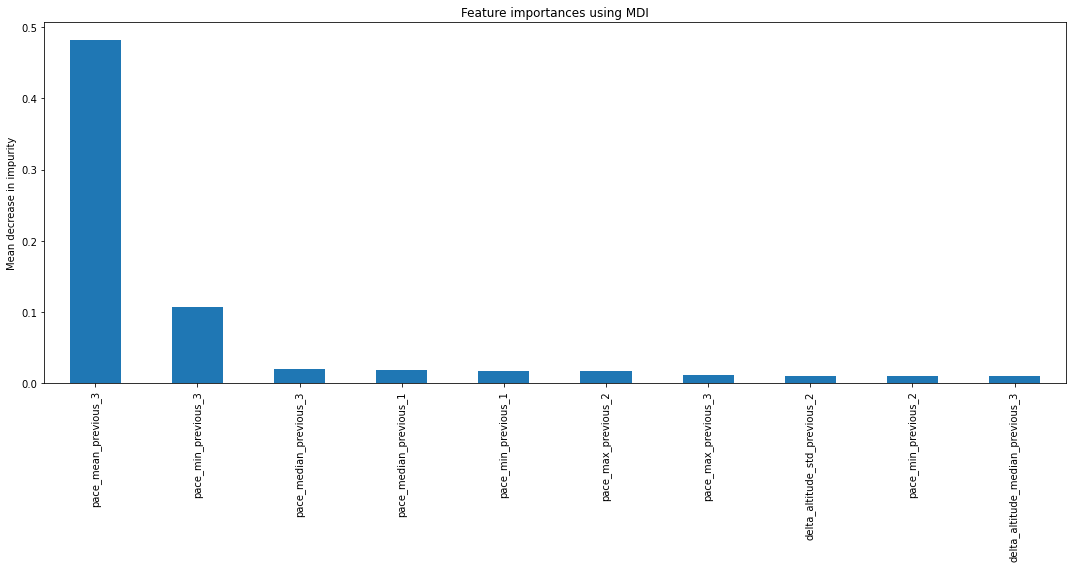

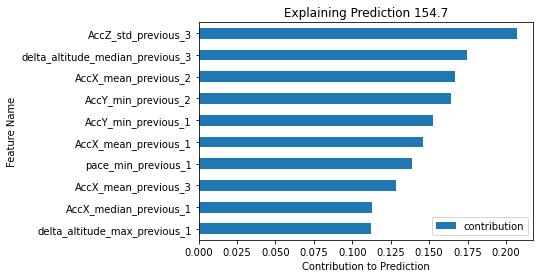

<Figure size 432x288 with 0 Axes>

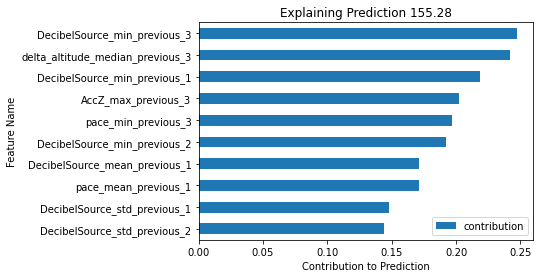

<Figure size 432x288 with 0 Axes>

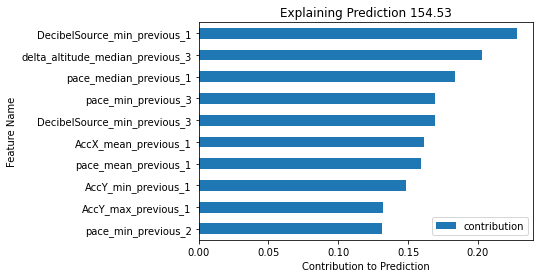

>> LOCO Tree
>> Removing Variable pace_mean_previous_3 when modelling
>> Removing Variable pace_min_previous_3 when modelling
>> Removing Variable pace_median_previous_3 when modelling
>> Removing Variable pace_median_previous_1 when modelling
>> Removing Variable pace_min_previous_1 when modelling
>> Removing Variable pace_max_previous_2 when modelling
>> Removing Variable pace_max_previous_3 when modelling
>> Removing Variable delta_altitude_std_previous_2 when modelling
>> Removing Variable pace_min_previous_2 when modelling
>> Removing Variable delta_altitude_median_previous_3 when modelling
>> Boostrap over Variable pace_mean_previous_3
>> Boostrap over Variable pace_min_previous_3
>> Boostrap over Variable pace_median_previous_3
>> Boostrap over Variable pace_median_previous_1
>> Boostrap over Variable pace_min_previous_1
>> Boostrap over Variable pace_max_previous_2
>> Boostrap over Variable pace_max_previous_3
>> Boostrap over Variable delta_altitude_std_previous_2
>> Boostrap 

<Figure size 432x288 with 0 Axes>

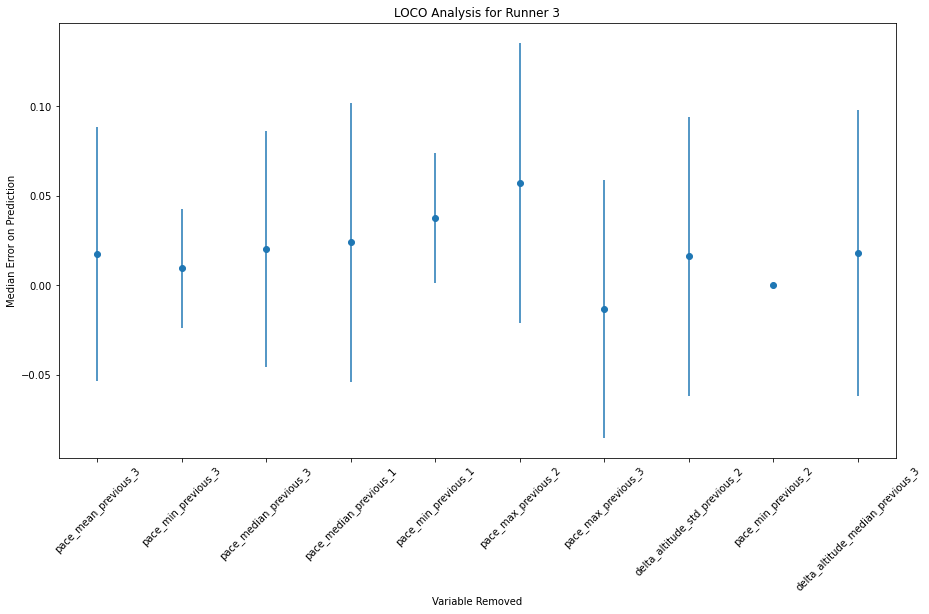

>> Get Top variable Poisson


<Figure size 432x288 with 0 Axes>

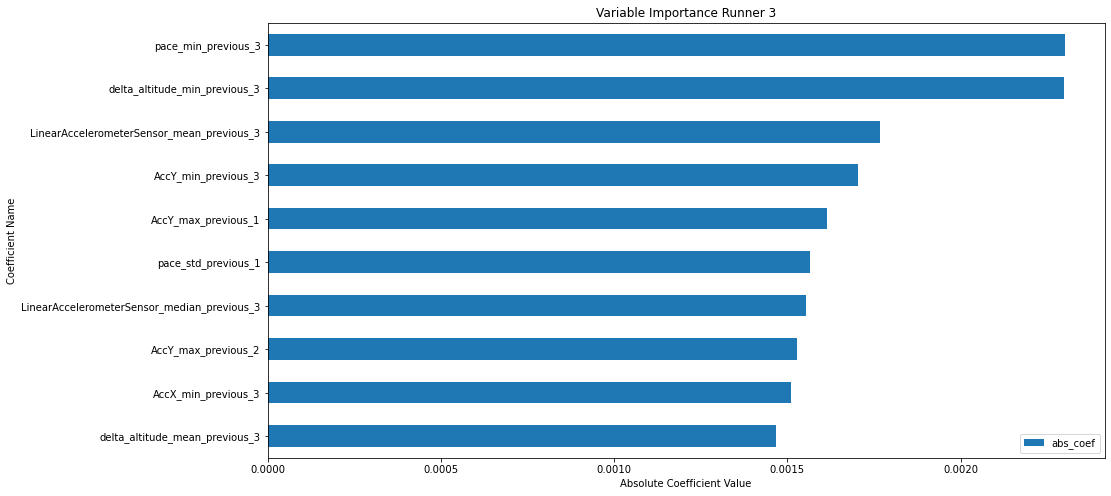

>> LOCO Poisson
>> Removing Variable pace_min_previous_3 when modelling
>> Removing Variable delta_altitude_min_previous_3 when modelling
>> Removing Variable LinearAccelerometerSensor_mean_previous_3 when modelling
>> Removing Variable AccY_min_previous_3 when modelling
>> Removing Variable AccY_max_previous_1 when modelling
>> Removing Variable pace_std_previous_1 when modelling
>> Removing Variable LinearAccelerometerSensor_median_previous_3 when modelling
>> Removing Variable AccY_max_previous_2 when modelling
>> Removing Variable AccX_min_previous_3 when modelling
>> Removing Variable delta_altitude_mean_previous_3 when modelling
>> Boostrap over Variable pace_min_previous_3
>> Boostrap over Variable delta_altitude_min_previous_3
>> Boostrap over Variable LinearAccelerometerSensor_mean_previous_3
>> Boostrap over Variable AccY_min_previous_3
>> Boostrap over Variable AccY_max_previous_1
>> Boostrap over Variable pace_std_previous_1
>> Boostrap over Variable LinearAccelerometerSens

<Figure size 432x288 with 0 Axes>

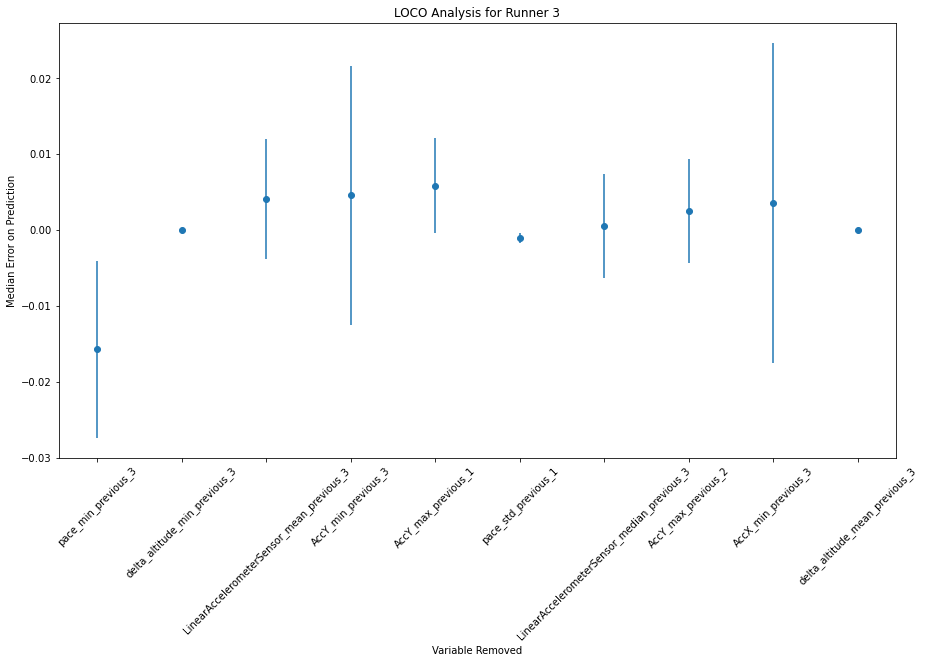

<Figure size 432x288 with 0 Axes>

In [364]:
interpretability('stefano', params_po=res_list[0][2], params_tree=res_list[3][2])
interpretability('juan', params_po=res_list[6][2], params_tree=res_list[9][2])
interpretability('leo', params_po=params_po_leo, params_tree=res_list[-1][2])

# ARIMA

In [4]:
def read_and_split(runner,summarize=True):
    
    # import and aggregate by min
    df= pd.read_csv('Data/'+runner+'_1_step_per_min.csv')
    df['day'] = [x[:10] for x in df.timestamp]                    
    df['min'] = [x[11:-3] for x in df.timestamp]

    # excluding weird sessions
    if runner == 'juan':
        df = df[df.day!= '2021-05-12'][df.day!='2021-06-17'].reset_index()
    
    last_session = df.day.unique()[-1]
    last_session_start = df[df.day==last_session].index[0]      # extract row corresponding to beginning of last session
    
    if summarize:
        sessions = df.groupby(df['min']).agg(set)['day']
        df = df.groupby(['min','day']).mean().reset_index()
        last_session = df.day.unique()[-1]
        last_session_start = df[df.day==last_session].index[0] - 1
    
    # test and train
    df = df.dropna()
    df = df.reset_index()
    y = df[['step_sum']]
    train = y[:last_session_start]
    test = y[last_session_start:]
    plt.figure(figsize=(20,8))
    plt.plot(train,color='#a8dadc')
    plt.plot(test,color='#ee6c4d')
    plt.legend(loc='lower right')
    plt.savefig(runner+'.png')

    
    # exog feature extraciton by correlation
    corr = df[['AccX_mean','AccY_mean','AccZ_mean','DecibelSource_mean','LinearAccelerometerSensor_mean','step_sum','delta_altitude_mean']].corr()['step_sum']
    exog_feature = abs(corr).sort_values().index[-2]
    print('Max correlation: ',exog_feature, '; ',corr[exog_feature])
    exog_train = df[exog_feature][:train.shape[0]]
    exog_test = df[exog_feature][train.shape[0]:]
    
    return (df,train,test,y,exog_train,exog_test)

In [5]:
def stationary_check(y):
    pvalue = adfuller(y)[1]
    print('Adfuller test pvalue: ',pvalue)
    return pvalue

In [6]:
def autocorrelation(y,runner):
    nlags = 30
    lags = acf(y,nlags=nlags)
    plt.figure(figsize=(20,7))
    plt.bar(range(nlags),lags[:nlags],color='#a8dadc')
    plt.xlabel('Lag')
    plt.ylabel('ACF')
    plt.savefig(runner+'_acf.png')
    plt.show()
    plt.figure(figsize=(20,7))
    autocorrelation_plot(y)
    plt.savefig(runner+'_auto.png')
    plt.show()
    plt.figure(figsize=(20,7))
    p_nlags = 30
    p_lags = pacf(y,p_nlags)
    plt.bar(range(p_nlags),p_lags[:p_nlags],color='#a8dadc')
    plt.ylabel('PACF')
    plt.xlabel('Lag')
    plt.savefig(runner+'_pacf.png')
    plt.show()
    return 1

In [8]:
#for tuning only
def arima(runner,train,test,start_p,start_q,max_p,max_q):
    model = auto_arima(train,start_p=1,d=0,start_q=1,max_p=30,max_q=10,seasonal=False)
    print(model.summary())
    prediction_train = pd.DataFrame(model.predict(n_periods=train.shape[0]),index=train.index)
    prediction_train.columns=['predicted_steps']
    RMSE_train = sklearn.metrics.mean_squared_error(train.step_sum,prediction_train.predicted_steps,squared=False)
    print('RMSE on train: ', RMSE_train)
    prediction_test = pd.DataFrame(model.predict(n_periods=test.shape[0]),index=test.index)
    prediction_test.columns=['predicted_steps']
    RMSE_test = sklearn.metrics.mean_squared_error(test.step_sum,prediction_test['predicted_steps'],squared=False)
    print('RMSE on test: ',RMSE_test)
    
    return RMSE_train,RMSE_test

In [9]:
def arima_exog(runner,train,test,p,q,exog_train,exog_test):
    model = ARIMA(endog=train,exog=exog_train, order=[p,0,q])
    model_fit = model.fit()
    print(model_fit.summary())
    RMSE_train = math.sqrt(sum(pd.DataFrame(model_fit.resid)**2)/len(train))
    print('RMSE on train: ',RMSE_train)
    fitted, x, ci = model_fit.forecast(len(test), exog=exog_test)
    RMSE_test = sklearn.metrics.mean_squared_error(test.step_sum,fitted,squared=False)
    print('RMSE on test: ',RMSE_test)
    ci_lower = [x[0] for x in ci]
    ci_upper = [x[1] for x in ci]
    plt.figure(figsize=(15,8))
    plt.plot(train, label='train',color='#3d5a80')
    plt.ylabel('BPM')
    plt.xlabel('Lag (min)')
    plt.plot(test,label='test',color='#98c1d9')
    plt.plot(test.index,fitted,label='prediction',color='#ee6c4d')
    plt.fill_between(test.index, 
                     ci_lower, 
                     ci_upper, 
                     color='#ee6c4d', alpha=.1)
    plt.title("Forecasting")
    plt.legend(loc='lower right')
    plt.savefig(runner+'model_exog.png')
    plt.show()
    return RMSE_train,RMSE_test

In [10]:
def arima_endog(runner,train,test,p,q):
    model = ARIMA(endog=train, order=[p,0,q])
    model_fit = model.fit()
    print(model_fit.summary())
    RMSE_train = math.sqrt(sum(pd.DataFrame(model_fit.resid)**2)/len(train))
    print('RMSE on train: ',RMSE_train)
    fitted, x, ci = model_fit.forecast(len(test))
    RMSE_test = sklearn.metrics.mean_squared_error(test.step_sum,fitted,squared=False)
    print('RMSE on test: ',RMSE_test)
    ci_lower = [x[0] for x in ci]
    ci_upper = [x[1] for x in ci]
    plt.figure(figsize=(15,8))
    plt.plot(train, label='train',color='#3d5a80')
    plt.ylabel('BPM')
    plt.xlabel('Lag (min)')
    plt.plot(test,label='test',color='#98c1d9')
    plt.plot(test.index,fitted,label='prediction',color='#ee6c4d')
    plt.fill_between(test.index, 
                     ci_lower, 
                     ci_upper, 
                     color='#ee6c4d', alpha=.1)
    plt.title("Forecasting")
    plt.legend(loc='lower right')
    plt.savefig(runner+'_forecasting.png')
    plt.show()
    return RMSE_train,RMSE_test

In [11]:
def predict(minutes,p,q,df):
    model = ARIMA(endog=df.step_sum, order=(p,0,q))
    model_fit = model.fit()
    pred,x,ci =model_fit.forecast(minutes)
    plt.figure(figsize=(15,8))
    plt.plot(df.step_sum, label='Observed',color='#3d5a80')
    plt.plot(range(len(df),len(df) + minutes), pred, label='Predictions',color='#3d5a80')
    ci_lower = [x[0] for x in ci]
    plt.ylabel('BPM')
    plt.xlabel('Lag (min)')
    ci_upper = [x[1] for x in ci]
    plt.fill_between(range(len(df),len(df) + minutes), 
                     ci_lower, 
                     ci_upper, 
                     color='#98c1d9', alpha=.2)
    plt.title("Forecasting")
    plt.legend(loc='lower right')
    plt.savefig('forecast_l.png')

No handles with labels found to put in legend.


Max correlation:  AccZ_mean ;  -0.3433293381512763
Adfuller test pvalue:  0.01862948889310836


/home/martina/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:568: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(


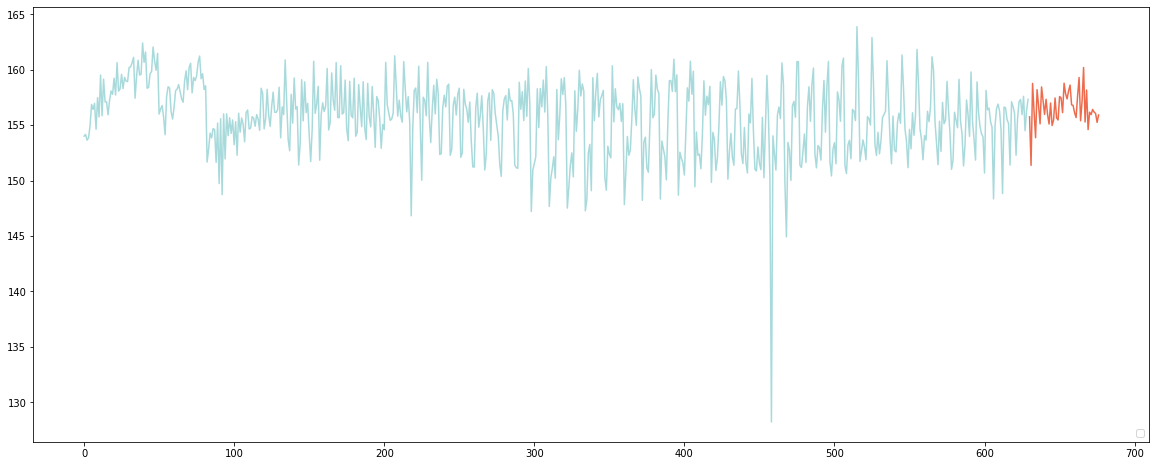

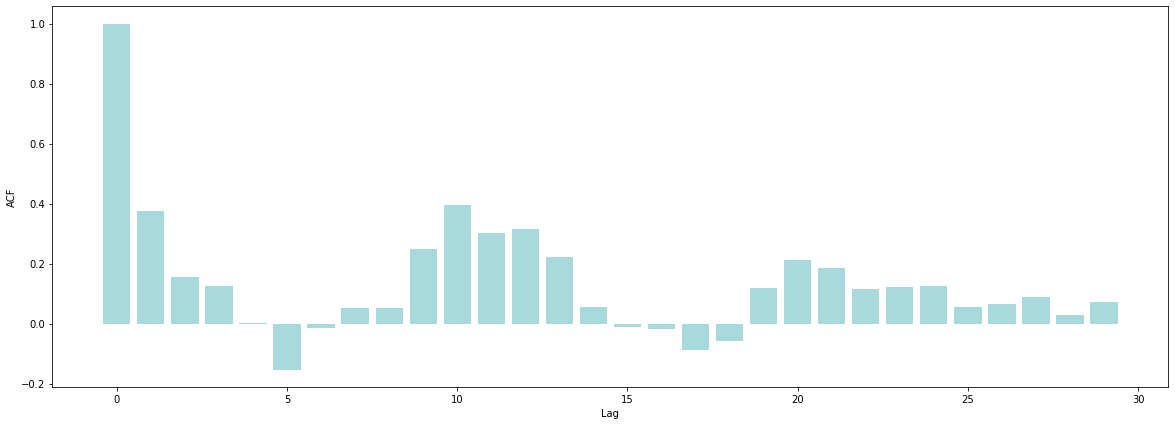

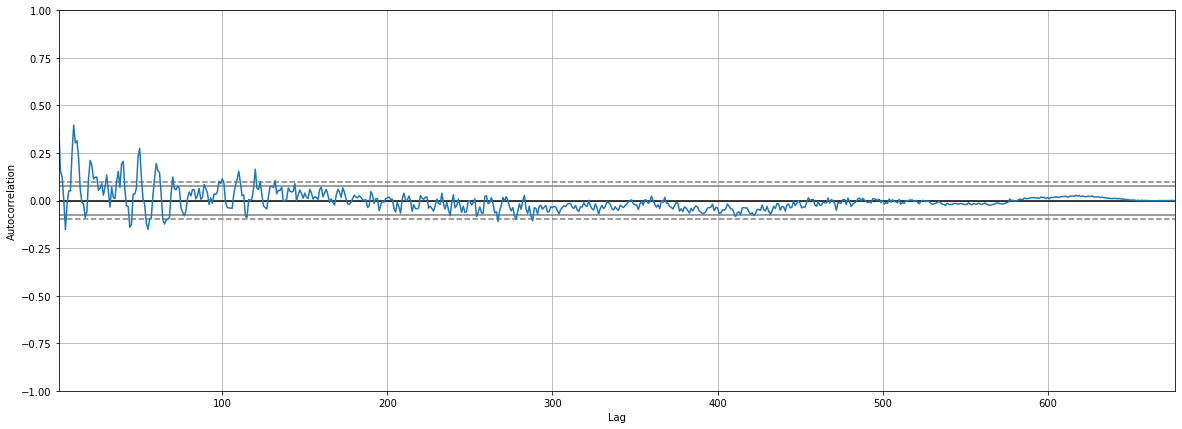

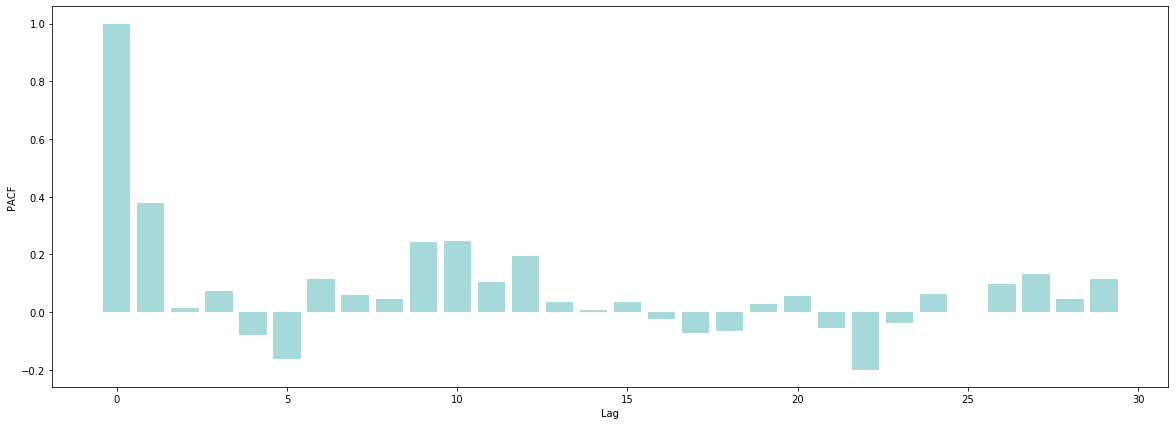

                              ARMA Model Results                              
Dep. Variable:               step_sum   No. Observations:                  630
Model:                     ARMA(1, 2)   Log Likelihood               -1564.773
Method:                       css-mle   S.D. of innovations              2.900
Date:                Sun, 18 Jul 2021   AIC                           3141.546
Time:                        19:36:15   BIC                           3168.220
Sample:                             0   HQIC                          3151.907
                                                                              
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const            164.3604      1.213    135.511      0.000     161.983     166.738
AccZ_mean         -3.7651      0.519     -7.260      0.000      -4.782      -2.749
ar.L1.step_sum     0.2921      0.299

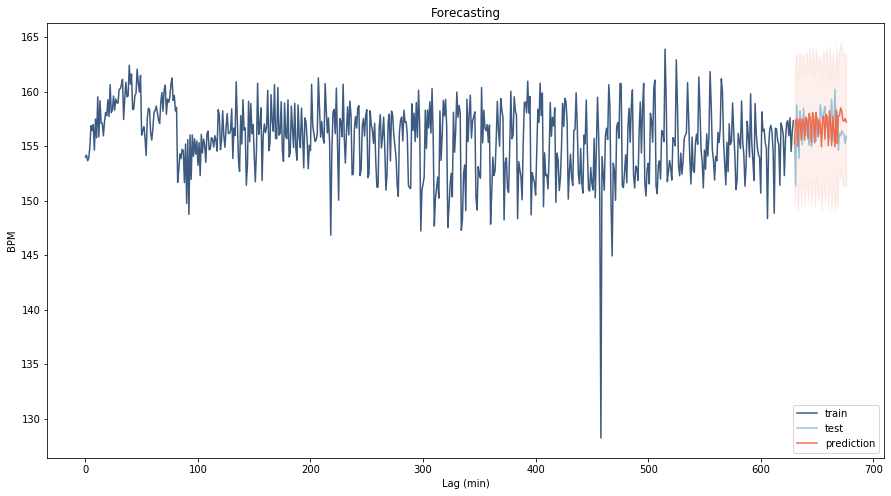

                              ARMA Model Results                              
Dep. Variable:               step_sum   No. Observations:                  630
Model:                     ARMA(1, 2)   Log Likelihood               -1583.717
Method:                       css-mle   S.D. of innovations              2.988
Date:                Sun, 18 Jul 2021   AIC                           3177.435
Time:                        19:36:16   BIC                           3199.663
Sample:                             0   HQIC                          3186.069
                                                                              
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const            155.7444      0.544    286.256      0.000     154.678     156.811
ar.L1.step_sum     0.9883      0.012     85.740      0.000       0.966       1.011
ma.L1.step_sum    -0.6481      0.039

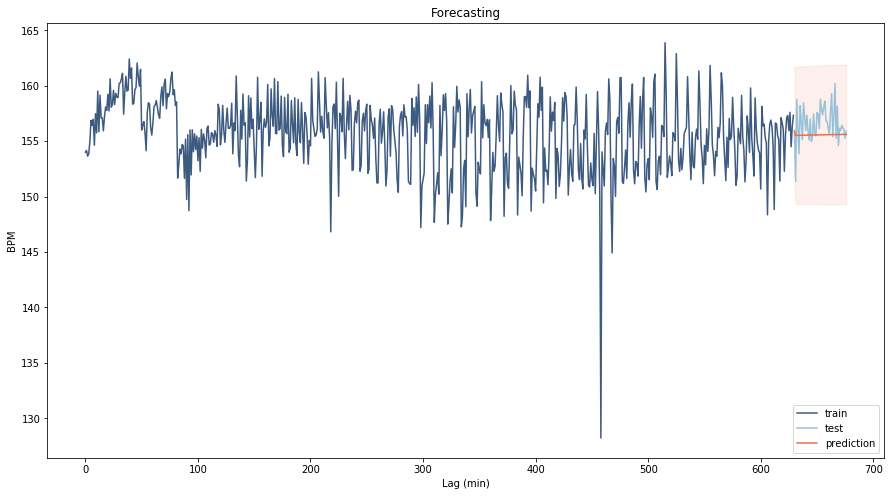

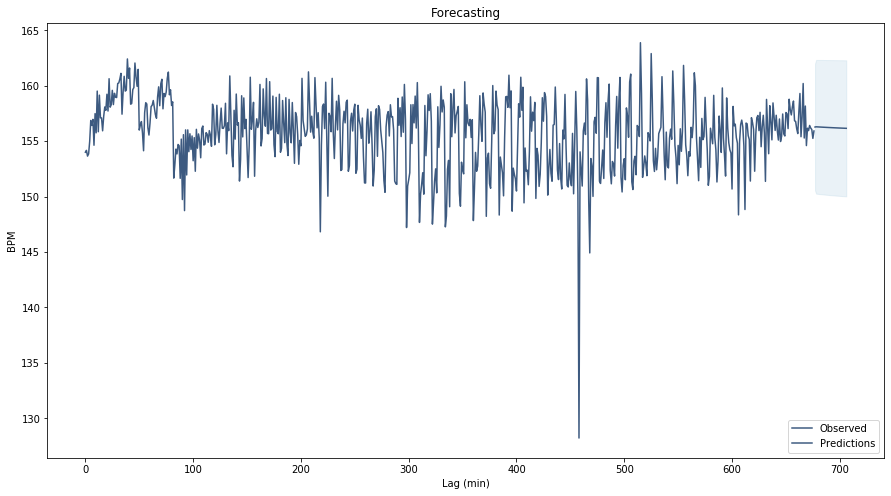

In [12]:
runner_1 = 'stefano'
df_1, train_1, test_1, y_1, exog_train_1, exog_test_1 = read_and_split(runner_1,summarize=True)
pvalue_1 = stationary_check(y_1)
autocorrelation(y_1,runner_1)
#rmse_train_1,rmse_test_1 = arima(runner_1,train_1,test_1,0,0,5,5)
rmse_train_exog_1,rmse_test_exog_1 = arima_exog(runner_1,train_1,test_1,1,2,exog_train_1,exog_test_1)
rmse_train_1,rmse_test_1 = arima_endog(runner_1,train_1,test_1,1,2)
predict(30,1,2,df_1)

<ipython-input-4-e8d128341193>:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[df.day!= '2021-05-12'][df.day!='2021-06-17'].reset_index()
No handles with labels found to put in legend.
/home/martina/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:568: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(


Max correlation:  LinearAccelerometerSensor_mean ;  0.4003302214525349
Adfuller test pvalue:  3.632847758619161e-20


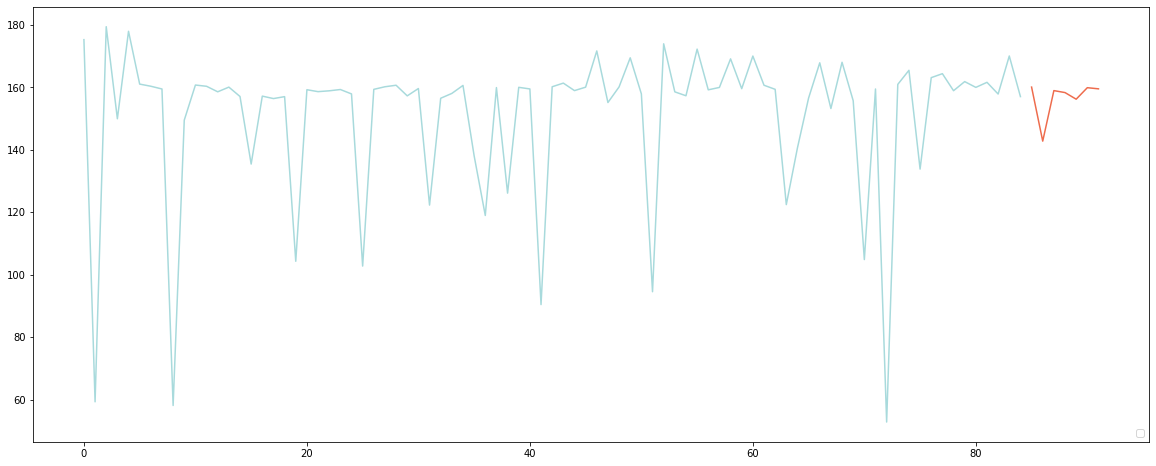

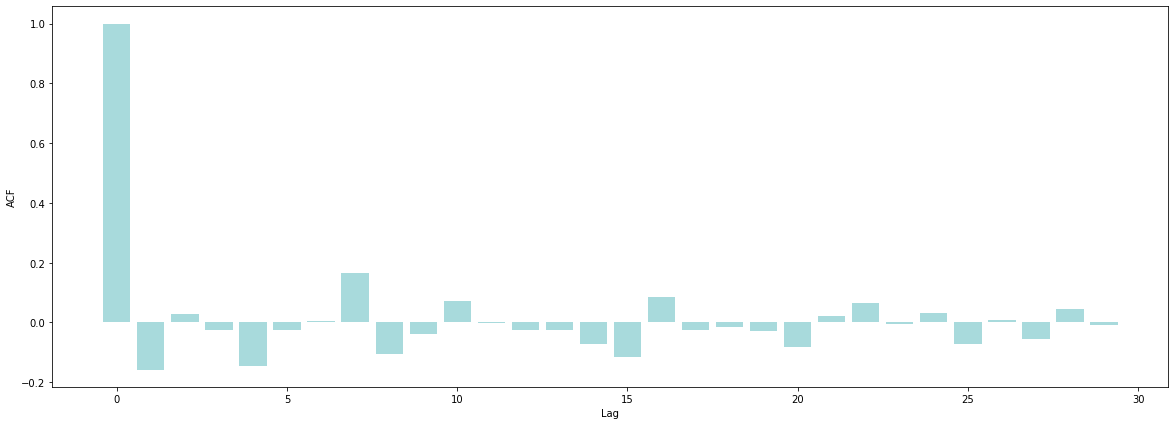

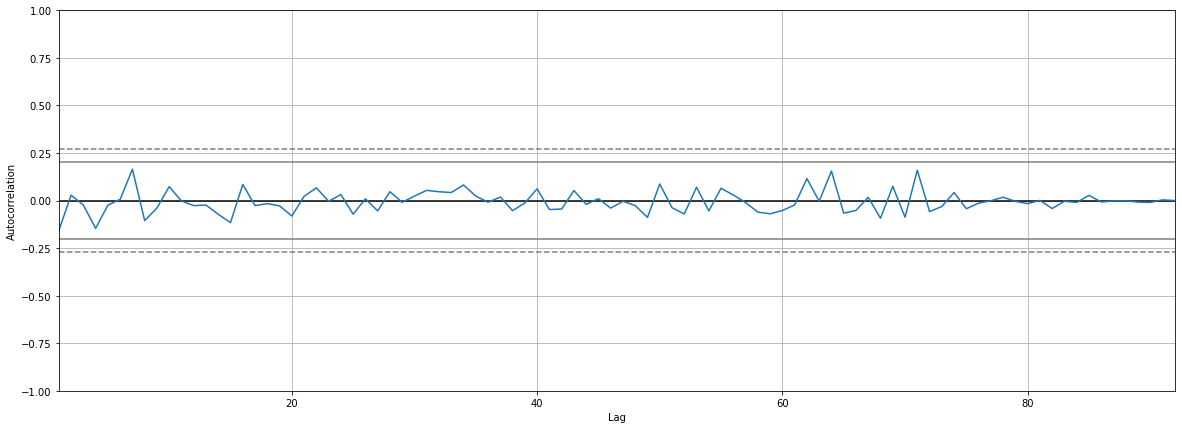

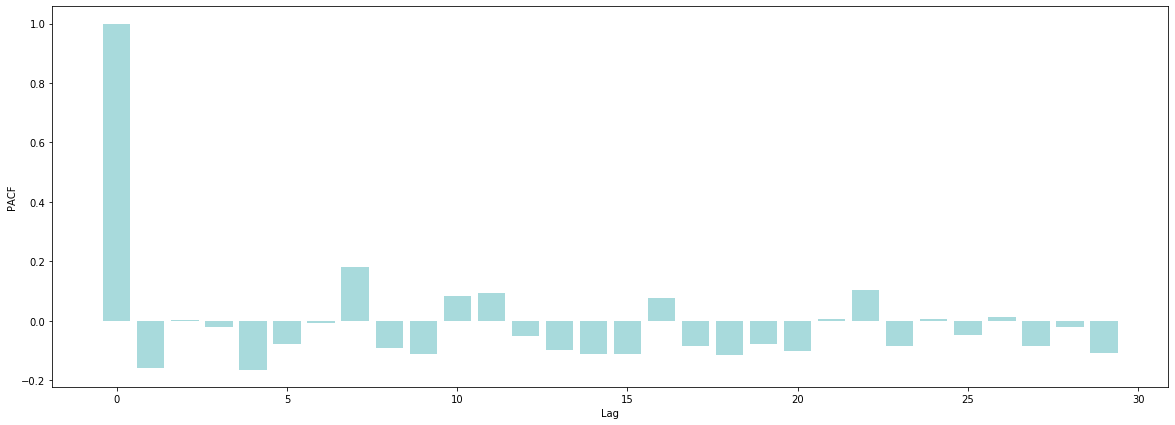

                              ARMA Model Results                              
Dep. Variable:               step_sum   No. Observations:                   85
Model:                     ARMA(1, 0)   Log Likelihood                -386.335
Method:                       css-mle   S.D. of innovations             22.784
Date:                Sun, 18 Jul 2021   AIC                            780.669
Time:                        19:36:19   BIC                            790.440
Sample:                             0   HQIC                           784.599
                                                                              
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                           -124.8281     70.002     -1.783      0.075    -262.029      12.372
LinearAccelerometerSensor_mean    18.4530      4.684      3.940      0.

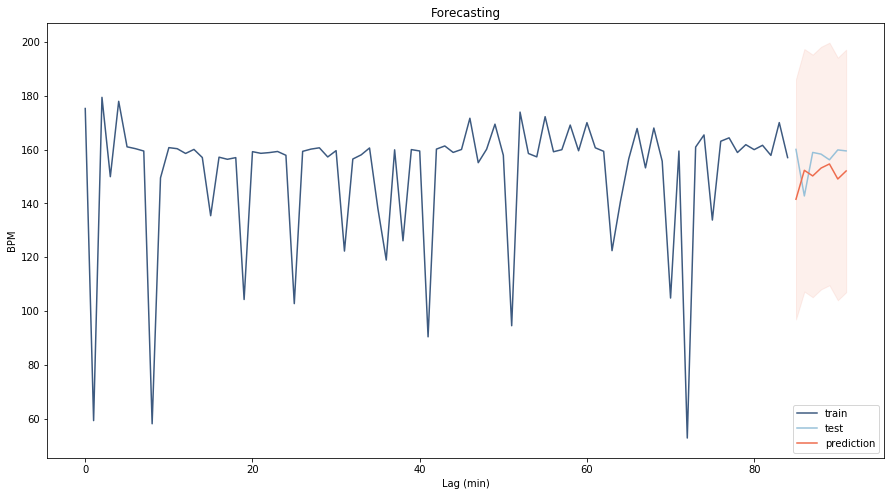

                              ARMA Model Results                              
Dep. Variable:               step_sum   No. Observations:                   85
Model:                     ARMA(1, 0)   Log Likelihood                -393.579
Method:                       css-mle   S.D. of innovations             24.810
Date:                Sun, 18 Jul 2021   AIC                            793.159
Time:                        19:36:19   BIC                            800.487
Sample:                             0   HQIC                           796.106
                                                                              
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const            150.8441      2.322     64.977      0.000     146.294     155.394
ar.L1.step_sum    -0.1612      0.107     -1.506      0.132      -0.371       0.049
                                    

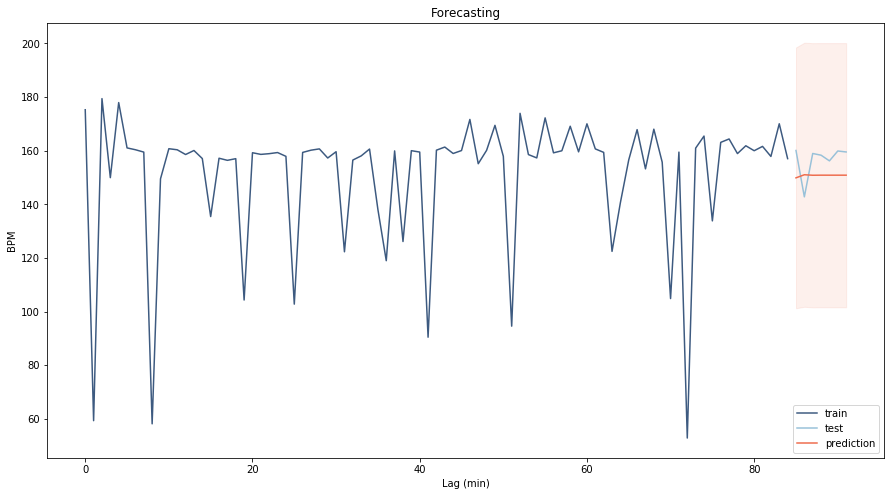

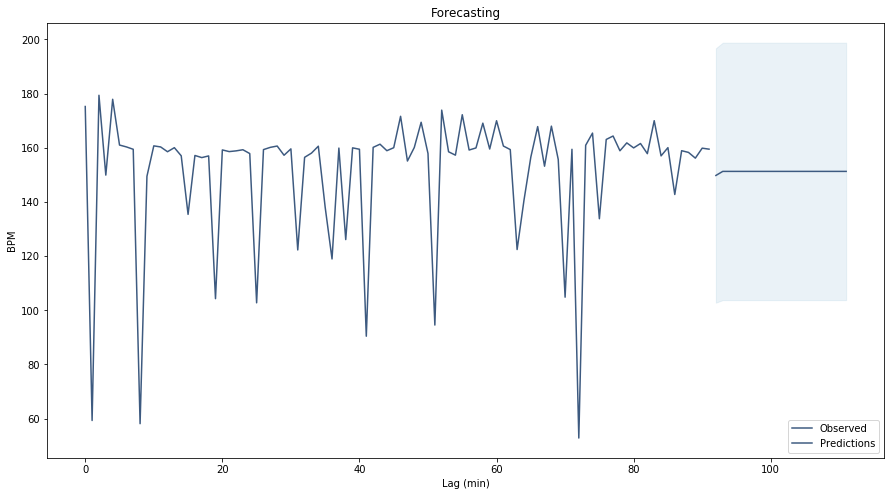

In [13]:
runner_2 = 'juan' 
df_2, train_2, test_2, y_2, exog_train_2, exog_test_2 = read_and_split(runner_2,summarize=True)
pvalue_2 = stationary_check(y_2)
autocorrelation(y_2,runner_2)
#rmse_train_2,rmse_test_2 = arima(runner_2,train_2,test_2,0,0,10,10)
rmse_train_exog_2,rmse_test_exog_2 = arima_exog(runner_2,train_2,test_2,1,0,exog_train_2,exog_test_2)
rmse_train_2,rmse_test_2 = arima_endog(runner_2,train_2,test_2,1,0)
predict(20,0,1,df_2)

No handles with labels found to put in legend.
/home/martina/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:568: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(


Max correlation:  LinearAccelerometerSensor_mean ;  -0.2680859411002177
Adfuller test pvalue:  1.4392671562439827e-13


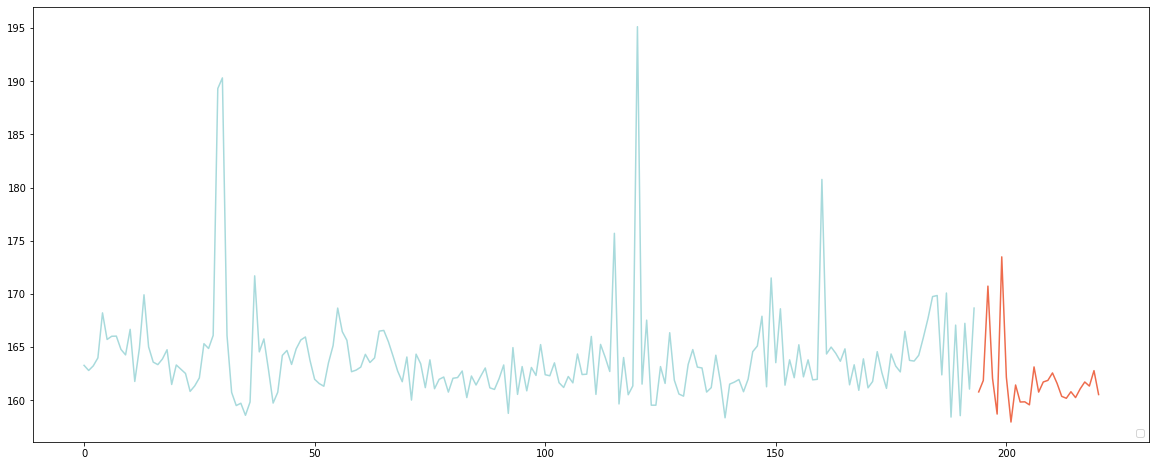

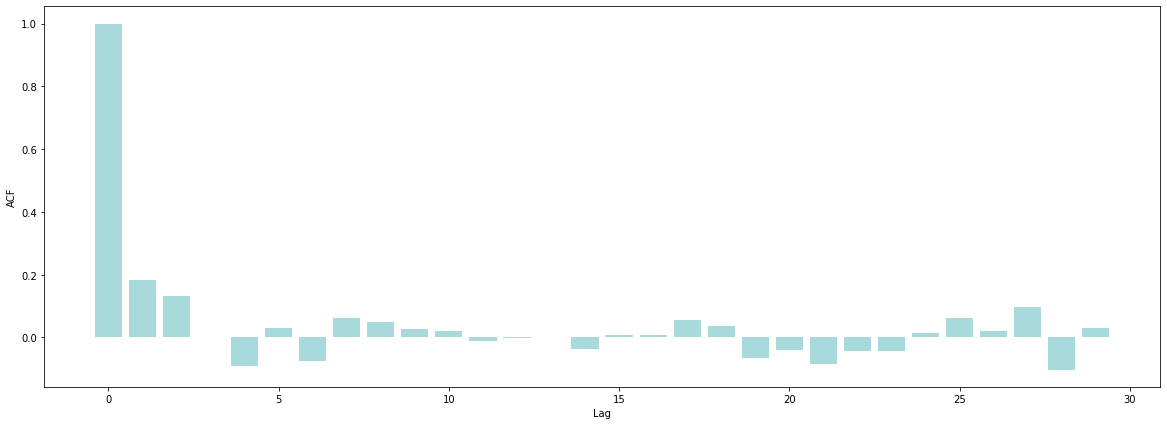

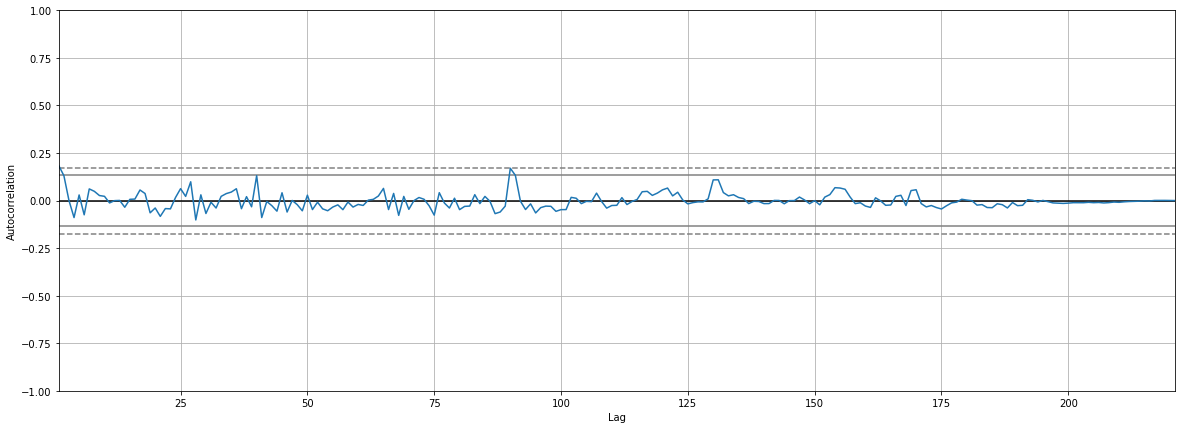

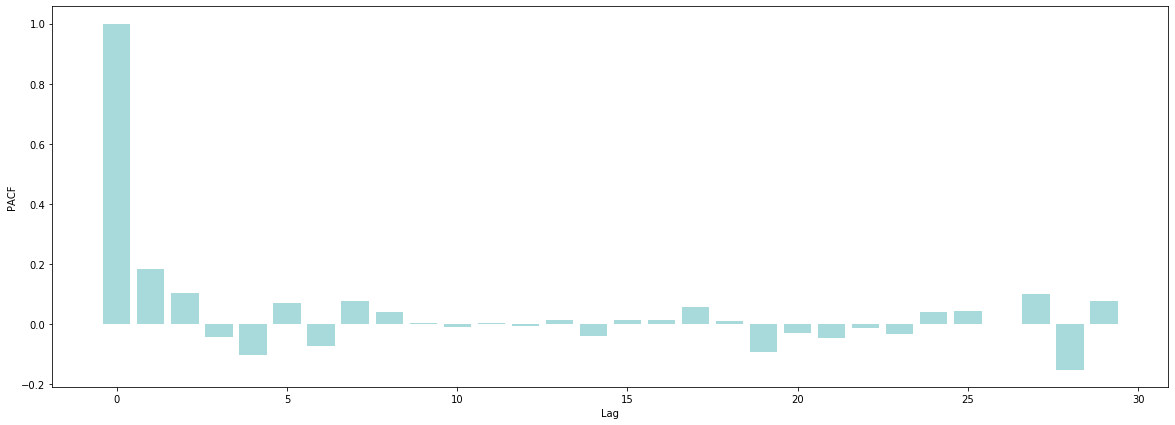

                              ARMA Model Results                              
Dep. Variable:               step_sum   No. Observations:                  194
Model:                     ARMA(0, 2)   Log Likelihood                -554.846
Method:                       css-mle   S.D. of innovations              4.224
Date:                Sun, 18 Jul 2021   AIC                           1119.692
Time:                        19:36:22   BIC                           1136.032
Sample:                             0   HQIC                          1126.309
                                                                              
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                            174.6145      2.744     63.647      0.000     169.237     179.992
LinearAccelerometerSensor_mean    -0.9047      0.230     -3.931      0.

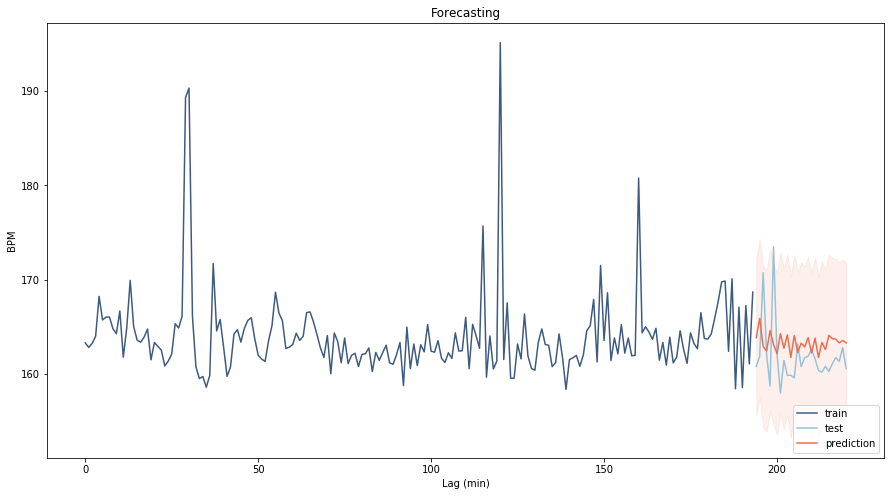

                              ARMA Model Results                              
Dep. Variable:               step_sum   No. Observations:                  194
Model:                     ARMA(0, 2)   Log Likelihood                -562.372
Method:                       css-mle   S.D. of innovations              4.391
Date:                Sun, 18 Jul 2021   AIC                           1132.745
Time:                        19:36:23   BIC                           1145.816
Sample:                             0   HQIC                          1138.038
                                                                              
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const            163.9520      0.437    375.009      0.000     163.095     164.809
ma.L1.step_sum     0.1869      0.071      2.643      0.008       0.048       0.326
ma.L2.step_sum     0.2028      0.078

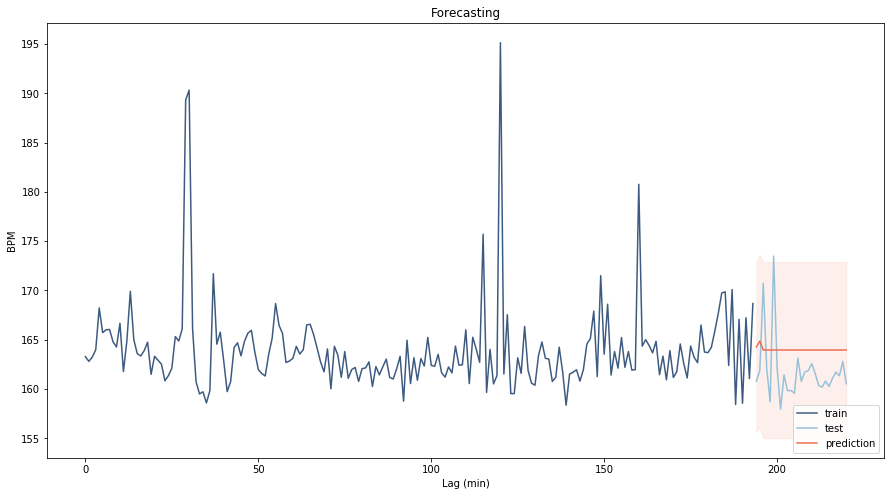

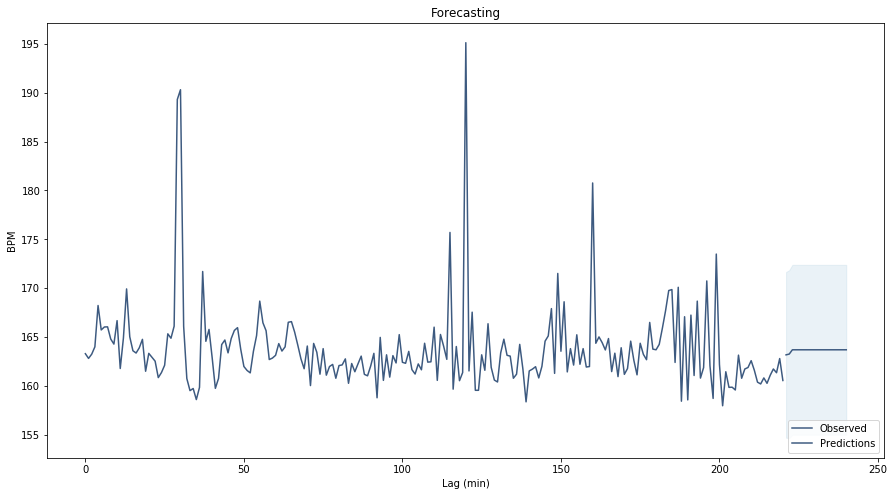

In [14]:
runner_3 = 'leo'
df_3, train_3, test_3, y_3, exog_train_3, exog_test_3 = read_and_split(runner_3, summarize=True)
pvalue_3 = stationary_check(y_3)
autocorrelation(y_3,runner_3)
#rmse_train_3,rmse_test_3 = arima(runner_3,train_3,test_3,0,0,10,10)
rmse_train_exog_3,rmse_test_exog_3 = arima_exog(runner_3,train_3,test_3,0,2,exog_train_3,exog_test_3)
rmse_train_3,rmse_test_3 = arima_endog(runner_3,train_3,test_3,0,2)
predict(20,0,2,df_3)